<a href="https://colab.research.google.com/github/1920039/cuk_vision/blob/main/vision_11_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

실습 파일: `11-gan.ipynb`

**모델 및 소스코드 참고**  

David Foster저 Generative Deep Learning (O'REILLY출판, 2019)


# Autoencoder

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import os

SAVE_FOLDER = 'data'

if not os.path.exists(SAVE_FOLDER):
    os.mkdir(SAVE_FOLDER)
    os.mkdir(os.path.join(SAVE_FOLDER, 'weights'))

In [24]:

MODE =  'build' #'load' #
#MODE =  'load'

**Encoder 모델 정의**

In [25]:
z_dim = 2    # latent vector의 dimension이 작아서 좋은 결과를 얻기 어렵지만, latent vector의 분포를 시각화하여 보기 편하기 때문에 2차원 사용

encoder_input = keras.Input(shape=(28, 28, 1), name='encoder_input')
x = Conv2D(32, 3, strides=1, padding="same", name='encoder_conv_0')(encoder_input)
x = LeakyReLU()(x)           # LeakyReLU 다음에 ()를 쓰고 다시 (x)를 씀에 유의
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_1')(x)     # strides=2이니 크기가 1/2로 줄어듬
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=1, padding="same", name='encoder_conv_3')(x)
x = LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]      # K.int_shape은 shape을 튜플로 반환함...참고로 K.shape은 텐서로 반환
                                                  # [1:]이라고 썼으니, x.shape = (None, 7, 7, 64)에서 두번째 것부터 사용하여 (7, 7, 64)가 됨
x = Flatten()(x)
encoder_output= Dense(z_dim, name='encoder_output')(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

디코더 모델 만들기

In [26]:
decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)      # np.prod는 element들의 곱. 여기서는 7 x 7 x 64가 됨
x = Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, strides=1, padding="same", name='decoder_conv_t0')(x)    # Conv2DTranspose에서 strides=1이므로 일반 conv와 동일함
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t1')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", name='decoder_conv_t2')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(1, 3, strides=1, padding="same", name='decoder_conv_t3')(x)     # (None, 28, 28, 32) --> (None, 28, 28, 1) : 노드가 1개니 shape의 마지막 값이 1로 바뀜(흑백 이미지)
                                                                                           # 컬러 이미지라면 3을 써서 원래의 이미지에 가깝게 복원할 수 있을까? (있을 듯)     
decoder_output = Activation('sigmoid')(x)          # image를 0~1 사이로 normalize하는 걸 표준으로 삼았기 때문에, 그걸 그대로 사용
decoder = keras.Model(decoder_input, decoder_output, name="decoder")

In [27]:
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 7, 7, 64)          0   

In [28]:
class AutoEncoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):    # **kwargs는 a = b 형식으로 인자를 받아서 딕셔너리를 생성. 여기서는 실제 사용하지는 않음
        super(AutoEncoder, self).__init__(**kwargs)    # 의미? super().__init__(변수명)은 부모 class의 __init()__ 함수를 호출하는 것인데, super() 안에 AutoEncoder를 쓰는 것은 왜?????????????
        self.encoder = encoder
        self.decoder = decoder
    def call(self,inputs):
        latent = self.encoder(inputs)      # inputs --> latent
        return self.decoder(latent)        # latent --> outputs 

@tf.function     # 아래의 셀 설명 참조
def r_loss(y_true, y_pred):         # reconstruction loss
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])   # MSE. axis 1,2,3 각각에 대해 mean ( = reduce_mean과 다른가?)

LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0
EPOCHS = 200

In [29]:
# @는 장식자(decorator)로서 그 다음에 오는 함수를 감싸주면서(=wrapper의 일종) 새로운 기능도 추가
# 여기서 '새로운 기능'이라 함은 tf.function의 기능임.

# 참고로 wrapper에는 decorator도 있고, adapter도 있음
# 아래의 '@tf.function' 부분을
# 장식자를 사용하지 않고 그 다음에 오는 함수를 바로 인자로 넣어서 다음과 같이 쓸 수도 있음
# tf.function(compute_loss_and_grads(~~~))

# tf.function() 함수는 그 다음에 오는 compute_loss_and_grads() 함수를 인자로 받아서 Autograph라는 기능을 추가
# Autograph는 파이썬 문법으로서, 그래프(Graph)를 컨트롤할 수 있게 해줌. 
# 보다 구체적으로 설명하면,
# 여기서는 GradientTape이 계산에 관계되는 모든 변수와 연산을 추적하기 때문에 performance에 영향을 주는데,
# tf.function 장식자를 붙이면 이 연산들을 고성능의 그래프 연산으로 변환하기 때문에 performance를 개선할 수 있음
# 통상 파이썬 코드가 실행 시 계산됨에 비해 그래프 연산은 사전 컴파일되어 실행 속도가 빨라짐.

In [30]:
save_folder = os.path.join(SAVE_FOLDER, 'weights')

ae = AutoEncoder(encoder, decoder)   # 객체 생성
ae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=r_loss) 

if MODE == 'build':
    x = np.random.rand(1,28,28,1)
    ae.predict(x)
    ae.save(save_folder)     # 중간중간에 저장해 둠. 속도가 빨라서 굳이 필요하지 않음
else:
    ae = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})
    #ae.load_weights(save_folder+'/'+'checkpoint')

INFO:tensorflow:Assets written to: data/weights/assets


INFO:tensorflow:Assets written to: data/weights/assets


**학습하기**

In [33]:
# mnist 데이터 읽어오기
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))

x_train = x_train/255.
x_test = x_test/255.

# 매 epoch마다 모델 weights 저장
#lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
checkpoint = ModelCheckpoint(save_folder+'/'+'checkpoint', save_weights_only = False, verbose=1)

#callbacks_list = [checkpoint]
callbacks_list = []
ae.fit(x_train[:1000], x_train[:1000], epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list)
ae.save(save_folder)

Epoch 1/200
32/32 [==============================] - 3s 102ms/step - loss: 0.0640
Epoch 2/200
32/32 [==============================] - 3s 102ms/step - loss: 0.0590
Epoch 3/200
32/32 [==============================] - 3s 101ms/step - loss: 0.0568
Epoch 4/200
32/32 [==============================] - 3s 101ms/step - loss: 0.0557
Epoch 5/200
32/32 [==============================] - 3s 103ms/step - loss: 0.0547
Epoch 6/200
32/32 [==============================] - 3s 101ms/step - loss: 0.0540
Epoch 7/200
32/32 [==============================] - 3s 102ms/step - loss: 0.0536
Epoch 8/200
32/32 [==============================] - 3s 101ms/step - loss: 0.0529
Epoch 9/200
32/32 [==============================] - 3s 102ms/step - loss: 0.0524
Epoch 10/200
32/32 [==============================] - 3s 102ms/step - loss: 0.0519
Epoch 11/200
32/32 [==============================] - 3s 102ms/step - loss: 0.0514
Epoch 12/200
32/32 [==============================] - 3s 102ms/step - loss: 0.0513
Epoch 13/200


INFO:tensorflow:Assets written to: data/weights/assets


**모델 읽어들이기**

In [1]:

save_folder = os.path.join(SAVE_FOLDER, 'weights')
#AE = AutoEncoder(encoder, decoder)
#AE.load_weights(save_folder+'/'+'checkpoint')
AE = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})


NameError: ignored

**생성해 보기**

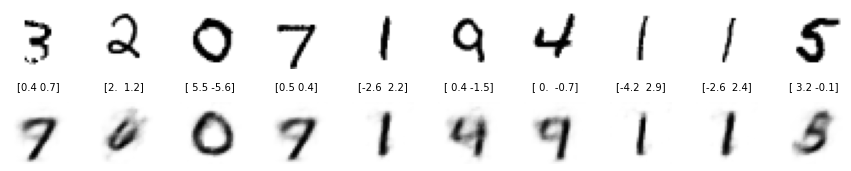

In [ ]:
import matplotlib.pyplot as plt

n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = AE.encoder.predict(example_images)

reconst_images = ae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


**Latent space의 분포**

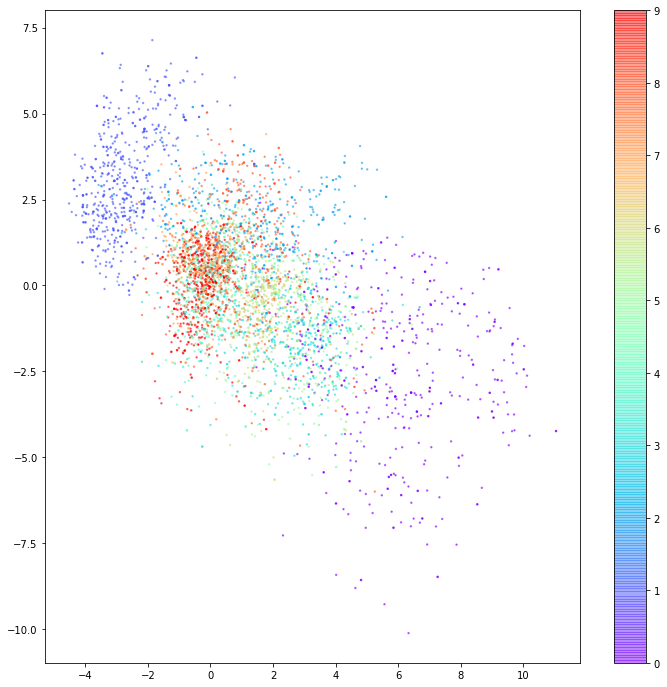

In [ ]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.show()

**Latent space에서 일정 간격으로 latent vector를 추출하여 생성된 결과**

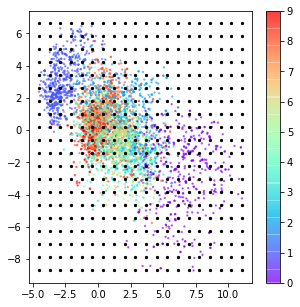

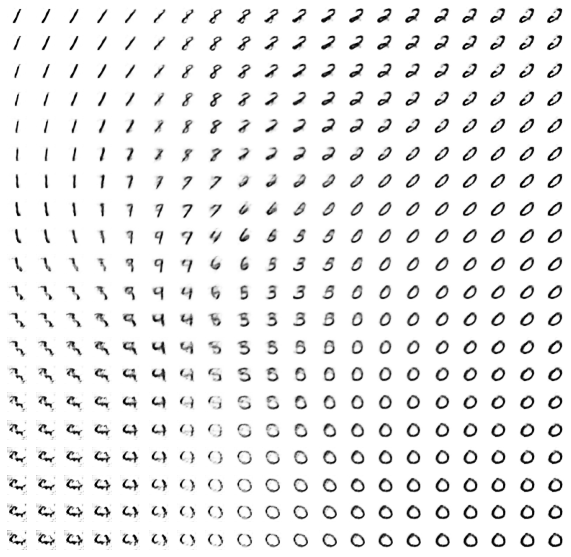

In [ ]:
n_to_show = 5000
grid_size = 20
figsize = 10

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)
plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

# GAN

In [ ]:
!mkdir -p gan_data/motorbike
!mkdir -p gan_data/images
!mkdir -p gan_data/weights
!gdown --id 1xBCbjopxZCvzzTMuRKKaTpF-i2jLz7xa -O gan_data/motorbike/full_numpy_bitmap_motorbike.npy


Downloading...
From: https://drive.google.com/uc?id=1xBCbjopxZCvzzTMuRKKaTpF-i2jLz7xa
To: /content/gan_data/motorbike/full_numpy_bitmap_motorbike.npy
100% 133M/133M [00:01<00:00, 94.0MB/s]


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, ReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Input, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
import os
from os import walk
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

**Quick! Draw! database**  
Dataset 홈페이지:  https://quickdraw.withgoogle.com/data  
Motorbike numpy 다운로드: https://console.cloud.google.com/storage/browser/_details/quickdraw_dataset/full/numpy_bitmap/motorbike.npy  

Quick & Draw 참여 페이지  
https://quickdraw.withgoogle.com/  


In [ ]:
# 넘파이를 읽어 들여서 안에 있는 이미지 데이터를 추출: 요즘엔 많이 쓰이지 않고 이 용도로만 쓰임

SAVE_FOLDER = 'gan_data'

def load_quickdraw(folder):

    mypath = os.path.join(SAVE_FOLDER, folder)
    txt_name_list = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        for f in filenames:
            if f != '.DS_Store':
                txt_name_list.append(f)
                break

    slice_train = int(80000/len(txt_name_list))  ###Setting value to be 80000 for the final dataset
    i = 0
    seed = np.random.randint(1, 10e6)

    for txt_name in txt_name_list:
        txt_path = os.path.join(mypath,txt_name)
        x = np.load(txt_path)
        x = (x.astype('float32') - 127.5) / 127.5
        # x = x.astype('float32') / 255.0

        x = x.reshape(x.shape[0], 28, 28, 1)

        y = [i] * len(x)
        np.random.seed(seed)
        np.random.shuffle(x)
        np.random.seed(seed)
        np.random.shuffle(y)
        x = x[:slice_train]
        y = y[:slice_train]
        if i != 0:
            xtotal = np.concatenate((x,xtotal), axis=0)
            ytotal = np.concatenate((y,ytotal), axis=0)
        else:
            xtotal = x
            ytotal = y
        i += 1

    return xtotal, ytotal

In [ ]:
x_train, y_train = load_quickdraw('motorbike')

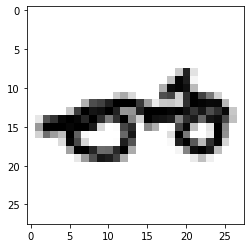

In [ ]:
plt.imshow(x_train[501,:,:,0], cmap = 'binary')
plt.show()

입력 이미지 사이즈: (28,28)

In [ ]:
input_dim = (28,28,1)
# weights들이 너무 튀지 않도록 하기 위해 weights initialization (여기서는 정의만, 나중에 conv에서 사용)
weight_init = RandomNormal(mean=0., stddev=0.02)   

**Discriminator 모델 정의**

In [ ]:
discriminator_input = keras.Input(shape=input_dim, name='discriminator_input')
x = Conv2D(64, 5, strides=2, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_0')(discriminator_input)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(64, 5, strides=2, padding="same",
    kernel_initializer=weight_init, name='discriminator_conv_1')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(128, 5, strides=2, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_2')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(128, 5, strides=1, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_3')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Flatten()(x)
discriminator_output = Dense(1, activation='sigmoid',    # 참, 거짓 둘 중 하나만 출력하면 됨
    kernel_initializer = RandomNormal(mean=0., stddev=0.02))(x)
discriminator = keras.Model(discriminator_input, discriminator_output, name = 'discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (InputL  [(None, 28, 28, 1)]      0         
 ayer)                                                           
                                                                 
 discriminator_conv_0 (Conv2  (None, 14, 14, 64)       1664      
 D)                                                              
                                                                 
 re_lu (ReLU)                (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 discriminator_conv_1 (Conv2  (None, 7, 7, 64)         102464    
 D)                                                              
                                                     

**Generator 모델 정의**

In [ ]:
z_dim = 100      # 보통 100 이상 사용함. 클수록 더 그럴듯한 이미지를 생성

generator_input = keras.Input(shape=(z_dim,), name='generator_input')
x = Dense(np.prod((7, 7, 64)), kernel_initializer = weight_init)(generator_input)
x = BatchNormalization(momentum=0.9)(x)    # normalize를 할 때 momentum을 줌. SGD에서 momentum을 주었던 것과 동일
x = ReLU()(x)
x = Reshape((7,7,64))(x)
x = UpSampling2D()(x)
x = Conv2D(128, 5, padding="same", kernel_initializer=weight_init, name='generator_conv_0')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(64, 5, padding="same", kernel_initializer=weight_init, name='generator_conv_1')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
# Conv2DTranspose이지만 strides=1이므로 일반 conv와 동일함 #############
x = Conv2DTranspose(64, 5, strides=1, padding="same", kernel_initializer=weight_init, name='generator_conv_2')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Conv2DTranspose(1, 5, strides=1, padding="same", kernel_initializer=weight_init, name='generator_conv_3')(x)
generator_output = Activation('tanh')(x)  # tanh니까 출력은 -1 ~ 1 나옴
generator = keras.Model(generator_input, generator_output, name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 100)]            0         
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 re_lu_4 (ReLU)              (None, 3136)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0 

Discriminator를 먼저 컴파일

In [ ]:
### COMPILE DISCRIMINATOR

discriminator.compile(
  optimizer=RMSprop(lr=0.0008),
  loss = 'binary_crossentropy',
  metrics = ['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Discriminator를 freeze하고, generator와 연결하여  
model을 정의  
Generator용 모델 컴파일  

In [ ]:
### COMPILE THE FULL GAN

def set_trainable(m, val):
    m.trainable = val
    for l in m.layers:
        l.trainable = val

# 먼저discriminator를 훈련 불가능 상태로 만듬.
set_trainable(discriminator, False)

model_input = Input(shape=(z_dim,), name='model_input')
model_output = discriminator(generator(model_input))    # model_input는 z(100 dim)
model = Model(model_input, model_output)

model.compile(optimizer=RMSprop(learning_rate=0.0004) , loss='binary_crossentropy', metrics=['accuracy']
  , experimental_run_tf_function=False
)

# compile이 완료되었으므로, discriminator를 훈련 가능 상태로 복귀.
set_trainable(discriminator, True)

최초 실행시에는 `build`를 사용  
저장된 weights를 loading해서 계속할 때에는 `load`사용

In [ ]:
mode = 'build'
#mode = 'load' (저장한 것을 불러올 때 사용)

if mode == 'build':
    model.save(SAVE_FOLDER)
else:
    model.load_weights(os.path.join(SAVE_FOLDER, 'weights/weights.h5'))

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


d,g의 loss 및 accuracy를 저장해 두는 변수

In [ ]:
total_epoch = 0
d_losses = []
g_losses = []

**GAN 학습**

In [ ]:
def train_discriminator(x_train, batch_size):

    valid = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    true_imgs = x_train[idx]

    noise = np.random.normal(0, 1, (batch_size, z_dim))   # 표준정규분포. 평균 0, 표준편차 1
    gen_imgs = generator.predict(noise)

    d_loss_real, d_acc_real =   discriminator.train_on_batch(true_imgs, valid)   # true_imgs에는 1을 줌
    d_loss_fake, d_acc_fake =   discriminator.train_on_batch(gen_imgs, fake)     # gen_imgs에는 0을 줌
    d_loss =  0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]

def train_generator(batch_size):
    valid = np.ones((batch_size,1))     # generator는 결과가 1이 나오도록 노력
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    return model.train_on_batch(noise, valid)



# 중간 epoch에서 생성 이미지를 샘플링하여 저장해두기 위한 함수
def sample_images(run_folder):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * (gen_imgs + 1)
    gen_imgs = np.clip(gen_imgs, 0, 1)

    fig, axs = plt.subplots(r, c, figsize=(15,15))
    cnt = 0

    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % total_epoch))
    plt.close()

# discriminator와 generator를 번갈아가며, 학습
def train(x_train, batch_size, epochs, run_folder,
          print_every_n_batches = 50,
          ):

    global total_epoch
    for epoch in range(total_epoch, total_epoch + epochs):

        # 매 epoch에서 discriminator와 generator를 번갈아 가면서 학습시킴
        d = train_discriminator(x_train, batch_size)      
        g = train_generator(batch_size)

        print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

        d_losses.append(d)
        g_losses.append(g)

        if epoch % print_every_n_batches == 0:
            sample_images(run_folder)
            #model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
            model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
            model.save(run_folder)

        total_epoch += 1


In [ ]:
BATCH_SIZE = 64
EPOCHS = 2000
PRINT_EVERY_N_BATCHES = 20

train(            # 앞서 정의한 함수임. 학습에 10분 정도 소요됨
    x_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    run_folder = SAVE_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
)

0 [D loss: (0.714)(R 0.700, F 0.729)] [D acc: (0.117)(0.234, 0.000)] [G loss: 0.682] [G acc: 1.000]
INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


1 [D loss: (0.760)(R 0.664, F 0.856)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.682] [G acc: 1.000]
2 [D loss: (0.684)(R 0.672, F 0.695)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.662] [G acc: 1.000]
3 [D loss: (0.696)(R 0.628, F 0.763)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.651] [G acc: 1.000]
4 [D loss: (1.489)(R 0.570, F 2.408)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.650] [G acc: 1.000]
5 [D loss: (0.712)(R 0.621, F 0.803)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.642] [G acc: 1.000]
6 [D loss: (0.679)(R 0.612, F 0.746)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.630] [G acc: 1.000]
7 [D loss: (0.675)(R 0.590, F 0.761)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.604] [G acc: 1.000]
8 [D loss: (0.709)(R 0.570, F 0.848)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.605] [G acc: 1.000]
9 [D loss: (0.667)(R 0.598, F 0.736)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.576] [G acc: 1.000]
10 [D loss: (0.651)(R 0.587, F 0.715)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.509] [G acc: 1.000]

INFO:tensorflow:Assets written to: gan_data/assets


21 [D loss: (0.068)(R 0.002, F 0.135)] [D acc: (0.977)(1.000, 0.953)] [G loss: 0.000] [G acc: 1.000]
22 [D loss: (0.194)(R 0.123, F 0.265)] [D acc: (0.922)(0.938, 0.906)] [G loss: 0.000] [G acc: 1.000]
23 [D loss: (0.375)(R 0.262, F 0.487)] [D acc: (0.867)(0.891, 0.844)] [G loss: 0.001] [G acc: 1.000]
24 [D loss: (0.629)(R 0.446, F 0.813)] [D acc: (0.766)(0.828, 0.703)] [G loss: 0.009] [G acc: 1.000]
25 [D loss: (0.287)(R 0.275, F 0.298)] [D acc: (0.844)(0.859, 0.828)] [G loss: 0.002] [G acc: 1.000]
26 [D loss: (0.531)(R 0.150, F 0.911)] [D acc: (0.805)(0.969, 0.641)] [G loss: 0.055] [G acc: 1.000]
27 [D loss: (2.185)(R 0.625, F 3.744)] [D acc: (0.336)(0.672, 0.000)] [G loss: 0.699] [G acc: 0.422]
28 [D loss: (0.558)(R 0.592, F 0.523)] [D acc: (0.953)(1.000, 0.906)] [G loss: 0.526] [G acc: 1.000]
29 [D loss: (0.301)(R 0.559, F 0.044)] [D acc: (0.953)(0.906, 1.000)] [G loss: 0.428] [G acc: 1.000]
30 [D loss: (0.790)(R 0.461, F 1.118)] [D acc: (0.484)(0.969, 0.000)] [G loss: 0.537] [G ac

INFO:tensorflow:Assets written to: gan_data/assets


41 [D loss: (0.688)(R 0.679, F 0.696)] [D acc: (0.625)(0.781, 0.469)] [G loss: 0.725] [G acc: 0.016]
42 [D loss: (0.700)(R 0.688, F 0.712)] [D acc: (0.578)(0.859, 0.297)] [G loss: 0.717] [G acc: 0.094]
43 [D loss: (0.716)(R 0.678, F 0.755)] [D acc: (0.398)(0.781, 0.016)] [G loss: 0.688] [G acc: 0.719]
44 [D loss: (0.687)(R 0.653, F 0.722)] [D acc: (0.539)(0.938, 0.141)] [G loss: 0.698] [G acc: 0.375]
45 [D loss: (0.699)(R 0.670, F 0.729)] [D acc: (0.414)(0.750, 0.078)] [G loss: 0.689] [G acc: 0.578]
46 [D loss: (0.614)(R 0.672, F 0.556)] [D acc: (0.828)(0.812, 0.844)] [G loss: 1.941] [G acc: 0.000]
47 [D loss: (1.070)(R 1.340, F 0.801)] [D acc: (0.086)(0.141, 0.031)] [G loss: 0.737] [G acc: 0.031]
48 [D loss: (0.705)(R 0.680, F 0.730)] [D acc: (0.375)(0.719, 0.031)] [G loss: 0.728] [G acc: 0.031]
49 [D loss: (0.697)(R 0.685, F 0.709)] [D acc: (0.453)(0.656, 0.250)] [G loss: 0.733] [G acc: 0.031]
50 [D loss: (0.695)(R 0.687, F 0.703)] [D acc: (0.445)(0.594, 0.297)] [G loss: 0.734] [G ac

INFO:tensorflow:Assets written to: gan_data/assets


61 [D loss: (0.663)(R 0.633, F 0.693)] [D acc: (0.664)(0.938, 0.391)] [G loss: 0.670] [G acc: 0.719]
62 [D loss: (0.612)(R 0.727, F 0.497)] [D acc: (0.625)(0.469, 0.781)] [G loss: 0.594] [G acc: 0.969]
63 [D loss: (0.416)(R 0.624, F 0.209)] [D acc: (0.875)(0.828, 0.922)] [G loss: 0.406] [G acc: 1.000]
64 [D loss: (1.028)(R 0.532, F 1.525)] [D acc: (0.469)(0.891, 0.047)] [G loss: 0.675] [G acc: 0.734]
65 [D loss: (0.648)(R 0.643, F 0.653)] [D acc: (0.680)(0.859, 0.500)] [G loss: 0.650] [G acc: 0.891]
66 [D loss: (0.713)(R 0.616, F 0.811)] [D acc: (0.477)(0.828, 0.125)] [G loss: 0.667] [G acc: 0.828]
67 [D loss: (0.702)(R 0.616, F 0.787)] [D acc: (0.461)(0.828, 0.094)] [G loss: 0.680] [G acc: 0.688]
68 [D loss: (0.698)(R 0.649, F 0.746)] [D acc: (0.539)(0.875, 0.203)] [G loss: 0.688] [G acc: 0.516]
69 [D loss: (0.699)(R 0.619, F 0.779)] [D acc: (0.477)(0.844, 0.109)] [G loss: 0.698] [G acc: 0.391]
70 [D loss: (0.690)(R 0.641, F 0.739)] [D acc: (0.547)(0.875, 0.219)] [G loss: 0.699] [G ac

INFO:tensorflow:Assets written to: gan_data/assets


81 [D loss: (0.710)(R 0.624, F 0.795)] [D acc: (0.508)(0.812, 0.203)] [G loss: 0.715] [G acc: 0.234]
82 [D loss: (0.675)(R 0.641, F 0.709)] [D acc: (0.641)(0.844, 0.438)] [G loss: 0.700] [G acc: 0.391]
83 [D loss: (0.647)(R 0.601, F 0.694)] [D acc: (0.688)(0.891, 0.484)] [G loss: 0.753] [G acc: 0.250]
84 [D loss: (0.753)(R 0.714, F 0.791)] [D acc: (0.391)(0.594, 0.188)] [G loss: 0.719] [G acc: 0.203]
85 [D loss: (0.662)(R 0.607, F 0.717)] [D acc: (0.633)(0.906, 0.359)] [G loss: 0.727] [G acc: 0.203]
86 [D loss: (0.662)(R 0.590, F 0.735)] [D acc: (0.562)(0.797, 0.328)] [G loss: 0.692] [G acc: 0.453]
87 [D loss: (0.649)(R 0.566, F 0.732)] [D acc: (0.609)(0.891, 0.328)] [G loss: 0.688] [G acc: 0.516]
88 [D loss: (0.633)(R 0.561, F 0.704)] [D acc: (0.633)(0.844, 0.422)] [G loss: 0.718] [G acc: 0.281]
89 [D loss: (0.804)(R 0.579, F 1.028)] [D acc: (0.391)(0.734, 0.047)] [G loss: 0.720] [G acc: 0.141]
90 [D loss: (0.650)(R 0.615, F 0.686)] [D acc: (0.742)(0.812, 0.672)] [G loss: 0.749] [G ac

INFO:tensorflow:Assets written to: gan_data/assets


101 [D loss: (0.644)(R 0.537, F 0.752)] [D acc: (0.578)(0.750, 0.406)] [G loss: 0.738] [G acc: 0.141]
102 [D loss: (0.575)(R 0.451, F 0.698)] [D acc: (0.750)(0.938, 0.562)] [G loss: 0.752] [G acc: 0.219]
103 [D loss: (0.816)(R 0.365, F 1.266)] [D acc: (0.570)(0.922, 0.219)] [G loss: 0.832] [G acc: 0.000]
104 [D loss: (0.579)(R 0.530, F 0.628)] [D acc: (0.820)(0.703, 0.938)] [G loss: 0.860] [G acc: 0.031]
105 [D loss: (0.454)(R 0.402, F 0.505)] [D acc: (0.797)(0.828, 0.766)] [G loss: 0.986] [G acc: 0.109]
106 [D loss: (0.600)(R 0.612, F 0.588)] [D acc: (0.836)(0.750, 0.922)] [G loss: 1.027] [G acc: 0.000]
107 [D loss: (0.573)(R 0.228, F 0.919)] [D acc: (0.648)(0.938, 0.359)] [G loss: 1.187] [G acc: 0.016]
108 [D loss: (0.661)(R 0.366, F 0.956)] [D acc: (0.594)(0.875, 0.312)] [G loss: 0.932] [G acc: 0.016]
109 [D loss: (0.440)(R 0.538, F 0.343)] [D acc: (0.820)(0.766, 0.875)] [G loss: 0.922] [G acc: 0.172]
110 [D loss: (0.513)(R 0.562, F 0.465)] [D acc: (0.875)(0.797, 0.953)] [G loss: 1.

INFO:tensorflow:Assets written to: gan_data/assets


121 [D loss: (0.618)(R 0.634, F 0.602)] [D acc: (0.711)(0.609, 0.812)] [G loss: 1.063] [G acc: 0.016]
122 [D loss: (0.633)(R 0.575, F 0.691)] [D acc: (0.656)(0.672, 0.641)] [G loss: 1.119] [G acc: 0.000]
123 [D loss: (0.607)(R 0.593, F 0.621)] [D acc: (0.664)(0.641, 0.688)] [G loss: 1.188] [G acc: 0.000]
124 [D loss: (0.619)(R 0.572, F 0.666)] [D acc: (0.648)(0.594, 0.703)] [G loss: 1.241] [G acc: 0.000]
125 [D loss: (0.638)(R 0.678, F 0.598)] [D acc: (0.648)(0.500, 0.797)] [G loss: 1.111] [G acc: 0.031]
126 [D loss: (0.598)(R 0.512, F 0.685)] [D acc: (0.664)(0.750, 0.578)] [G loss: 1.147] [G acc: 0.000]
127 [D loss: (0.618)(R 0.634, F 0.602)] [D acc: (0.695)(0.594, 0.797)] [G loss: 1.003] [G acc: 0.016]
128 [D loss: (0.669)(R 0.521, F 0.816)] [D acc: (0.648)(0.781, 0.516)] [G loss: 0.991] [G acc: 0.016]
129 [D loss: (0.569)(R 0.493, F 0.646)] [D acc: (0.758)(0.859, 0.656)] [G loss: 1.010] [G acc: 0.016]
130 [D loss: (0.604)(R 0.497, F 0.711)] [D acc: (0.719)(0.797, 0.641)] [G loss: 1.

INFO:tensorflow:Assets written to: gan_data/assets


141 [D loss: (0.703)(R 0.630, F 0.777)] [D acc: (0.500)(0.656, 0.344)] [G loss: 0.717] [G acc: 0.359]
142 [D loss: (0.683)(R 0.622, F 0.744)] [D acc: (0.516)(0.688, 0.344)] [G loss: 0.715] [G acc: 0.328]
143 [D loss: (0.707)(R 0.624, F 0.790)] [D acc: (0.453)(0.625, 0.281)] [G loss: 0.699] [G acc: 0.359]
144 [D loss: (0.698)(R 0.640, F 0.755)] [D acc: (0.461)(0.672, 0.250)] [G loss: 0.708] [G acc: 0.328]
145 [D loss: (0.679)(R 0.616, F 0.741)] [D acc: (0.586)(0.828, 0.344)] [G loss: 0.732] [G acc: 0.156]
146 [D loss: (0.679)(R 0.634, F 0.724)] [D acc: (0.555)(0.719, 0.391)] [G loss: 0.721] [G acc: 0.250]
147 [D loss: (0.677)(R 0.643, F 0.711)] [D acc: (0.547)(0.672, 0.422)] [G loss: 0.726] [G acc: 0.250]
148 [D loss: (0.673)(R 0.599, F 0.748)] [D acc: (0.547)(0.812, 0.281)] [G loss: 0.730] [G acc: 0.266]
149 [D loss: (0.671)(R 0.593, F 0.749)] [D acc: (0.578)(0.766, 0.391)] [G loss: 0.745] [G acc: 0.219]
150 [D loss: (0.669)(R 0.631, F 0.708)] [D acc: (0.578)(0.656, 0.500)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


161 [D loss: (0.679)(R 0.608, F 0.750)] [D acc: (0.539)(0.656, 0.422)] [G loss: 0.733] [G acc: 0.219]
162 [D loss: (0.662)(R 0.601, F 0.724)] [D acc: (0.625)(0.688, 0.562)] [G loss: 0.739] [G acc: 0.172]
163 [D loss: (0.687)(R 0.589, F 0.785)] [D acc: (0.516)(0.688, 0.344)] [G loss: 0.754] [G acc: 0.203]
164 [D loss: (0.658)(R 0.577, F 0.739)] [D acc: (0.555)(0.688, 0.422)] [G loss: 0.720] [G acc: 0.250]
165 [D loss: (0.685)(R 0.599, F 0.771)] [D acc: (0.477)(0.609, 0.344)] [G loss: 0.730] [G acc: 0.219]
166 [D loss: (0.680)(R 0.593, F 0.766)] [D acc: (0.492)(0.656, 0.328)] [G loss: 0.708] [G acc: 0.344]
167 [D loss: (0.679)(R 0.634, F 0.723)] [D acc: (0.523)(0.609, 0.438)] [G loss: 0.719] [G acc: 0.266]
168 [D loss: (0.690)(R 0.647, F 0.733)] [D acc: (0.484)(0.516, 0.453)] [G loss: 0.717] [G acc: 0.281]
169 [D loss: (0.686)(R 0.609, F 0.763)] [D acc: (0.523)(0.719, 0.328)] [G loss: 0.714] [G acc: 0.219]
170 [D loss: (0.673)(R 0.632, F 0.715)] [D acc: (0.516)(0.609, 0.422)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


181 [D loss: (0.680)(R 0.637, F 0.723)] [D acc: (0.609)(0.609, 0.609)] [G loss: 0.722] [G acc: 0.234]
182 [D loss: (0.671)(R 0.592, F 0.751)] [D acc: (0.586)(0.625, 0.547)] [G loss: 0.738] [G acc: 0.203]
183 [D loss: (0.671)(R 0.625, F 0.718)] [D acc: (0.586)(0.672, 0.500)] [G loss: 0.733] [G acc: 0.234]
184 [D loss: (0.694)(R 0.635, F 0.753)] [D acc: (0.508)(0.625, 0.391)] [G loss: 0.737] [G acc: 0.172]
185 [D loss: (0.680)(R 0.651, F 0.709)] [D acc: (0.602)(0.625, 0.578)] [G loss: 0.723] [G acc: 0.203]
186 [D loss: (0.702)(R 0.650, F 0.755)] [D acc: (0.539)(0.578, 0.500)] [G loss: 0.743] [G acc: 0.172]
187 [D loss: (0.695)(R 0.671, F 0.719)] [D acc: (0.516)(0.562, 0.469)] [G loss: 0.722] [G acc: 0.203]
188 [D loss: (0.688)(R 0.672, F 0.704)] [D acc: (0.531)(0.453, 0.609)] [G loss: 0.717] [G acc: 0.250]
189 [D loss: (0.713)(R 0.641, F 0.785)] [D acc: (0.438)(0.547, 0.328)] [G loss: 0.721] [G acc: 0.188]
190 [D loss: (0.681)(R 0.671, F 0.692)] [D acc: (0.578)(0.531, 0.625)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


201 [D loss: (0.683)(R 0.696, F 0.669)] [D acc: (0.602)(0.359, 0.844)] [G loss: 0.737] [G acc: 0.094]
202 [D loss: (0.691)(R 0.649, F 0.733)] [D acc: (0.570)(0.625, 0.516)] [G loss: 0.706] [G acc: 0.312]
203 [D loss: (0.704)(R 0.667, F 0.741)] [D acc: (0.469)(0.500, 0.438)] [G loss: 0.719] [G acc: 0.156]
204 [D loss: (0.704)(R 0.689, F 0.720)] [D acc: (0.367)(0.391, 0.344)] [G loss: 0.716] [G acc: 0.141]
205 [D loss: (0.694)(R 0.690, F 0.698)] [D acc: (0.492)(0.406, 0.578)] [G loss: 0.710] [G acc: 0.172]
206 [D loss: (0.688)(R 0.699, F 0.677)] [D acc: (0.562)(0.312, 0.812)] [G loss: 0.714] [G acc: 0.156]
207 [D loss: (0.694)(R 0.684, F 0.704)] [D acc: (0.523)(0.484, 0.562)] [G loss: 0.712] [G acc: 0.188]
208 [D loss: (0.681)(R 0.679, F 0.683)] [D acc: (0.562)(0.406, 0.719)] [G loss: 0.718] [G acc: 0.234]
209 [D loss: (0.704)(R 0.684, F 0.725)] [D acc: (0.414)(0.422, 0.406)] [G loss: 0.720] [G acc: 0.062]
210 [D loss: (0.694)(R 0.695, F 0.693)] [D acc: (0.492)(0.328, 0.656)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


221 [D loss: (0.686)(R 0.681, F 0.691)] [D acc: (0.508)(0.391, 0.625)] [G loss: 0.718] [G acc: 0.094]
222 [D loss: (0.697)(R 0.650, F 0.744)] [D acc: (0.500)(0.562, 0.438)] [G loss: 0.714] [G acc: 0.125]
223 [D loss: (0.684)(R 0.660, F 0.708)] [D acc: (0.531)(0.516, 0.547)] [G loss: 0.713] [G acc: 0.219]
224 [D loss: (0.666)(R 0.662, F 0.670)] [D acc: (0.672)(0.547, 0.797)] [G loss: 0.733] [G acc: 0.219]
225 [D loss: (0.681)(R 0.680, F 0.681)] [D acc: (0.539)(0.438, 0.641)] [G loss: 0.760] [G acc: 0.062]
226 [D loss: (0.812)(R 0.550, F 1.074)] [D acc: (0.500)(0.812, 0.188)] [G loss: 0.731] [G acc: 0.000]
227 [D loss: (0.678)(R 0.640, F 0.717)] [D acc: (0.555)(0.562, 0.547)] [G loss: 0.720] [G acc: 0.125]
228 [D loss: (0.676)(R 0.622, F 0.731)] [D acc: (0.547)(0.641, 0.453)] [G loss: 0.694] [G acc: 0.359]
229 [D loss: (0.672)(R 0.645, F 0.698)] [D acc: (0.617)(0.625, 0.609)] [G loss: 0.736] [G acc: 0.266]
230 [D loss: (0.673)(R 0.693, F 0.654)] [D acc: (0.672)(0.422, 0.922)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


241 [D loss: (0.698)(R 0.691, F 0.704)] [D acc: (0.500)(0.391, 0.609)] [G loss: 0.702] [G acc: 0.297]
242 [D loss: (0.685)(R 0.674, F 0.696)] [D acc: (0.539)(0.531, 0.547)] [G loss: 0.720] [G acc: 0.141]
243 [D loss: (0.682)(R 0.674, F 0.690)] [D acc: (0.578)(0.531, 0.625)] [G loss: 0.710] [G acc: 0.203]
244 [D loss: (0.698)(R 0.680, F 0.715)] [D acc: (0.500)(0.484, 0.516)] [G loss: 0.716] [G acc: 0.219]
245 [D loss: (0.681)(R 0.665, F 0.697)] [D acc: (0.594)(0.609, 0.578)] [G loss: 0.710] [G acc: 0.219]
246 [D loss: (0.693)(R 0.657, F 0.729)] [D acc: (0.523)(0.625, 0.422)] [G loss: 0.711] [G acc: 0.250]
247 [D loss: (0.688)(R 0.671, F 0.705)] [D acc: (0.555)(0.562, 0.547)] [G loss: 0.704] [G acc: 0.375]
248 [D loss: (0.688)(R 0.672, F 0.705)] [D acc: (0.500)(0.625, 0.375)] [G loss: 0.693] [G acc: 0.438]
249 [D loss: (0.699)(R 0.655, F 0.744)] [D acc: (0.477)(0.656, 0.297)] [G loss: 0.707] [G acc: 0.297]
250 [D loss: (0.694)(R 0.670, F 0.718)] [D acc: (0.469)(0.594, 0.344)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


261 [D loss: (0.627)(R 0.606, F 0.648)] [D acc: (0.766)(0.594, 0.938)] [G loss: 0.760] [G acc: 0.234]
262 [D loss: (0.878)(R 0.550, F 1.206)] [D acc: (0.383)(0.609, 0.156)] [G loss: 0.718] [G acc: 0.250]
263 [D loss: (0.677)(R 0.650, F 0.703)] [D acc: (0.617)(0.594, 0.641)] [G loss: 0.725] [G acc: 0.141]
264 [D loss: (0.710)(R 0.627, F 0.793)] [D acc: (0.523)(0.656, 0.391)] [G loss: 0.711] [G acc: 0.266]
265 [D loss: (0.706)(R 0.676, F 0.736)] [D acc: (0.438)(0.438, 0.438)] [G loss: 0.708] [G acc: 0.281]
266 [D loss: (0.687)(R 0.657, F 0.716)] [D acc: (0.523)(0.547, 0.500)] [G loss: 0.707] [G acc: 0.328]
267 [D loss: (0.689)(R 0.658, F 0.719)] [D acc: (0.586)(0.594, 0.578)] [G loss: 0.706] [G acc: 0.359]
268 [D loss: (0.685)(R 0.675, F 0.695)] [D acc: (0.531)(0.531, 0.531)] [G loss: 0.733] [G acc: 0.172]
269 [D loss: (0.694)(R 0.698, F 0.689)] [D acc: (0.570)(0.500, 0.641)] [G loss: 0.727] [G acc: 0.156]
270 [D loss: (0.685)(R 0.670, F 0.699)] [D acc: (0.586)(0.562, 0.609)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


281 [D loss: (0.678)(R 0.670, F 0.686)] [D acc: (0.594)(0.469, 0.719)] [G loss: 0.719] [G acc: 0.078]
282 [D loss: (0.691)(R 0.604, F 0.777)] [D acc: (0.555)(0.641, 0.469)] [G loss: 0.729] [G acc: 0.047]
283 [D loss: (0.678)(R 0.644, F 0.713)] [D acc: (0.594)(0.531, 0.656)] [G loss: 0.727] [G acc: 0.094]
284 [D loss: (0.685)(R 0.651, F 0.719)] [D acc: (0.531)(0.438, 0.625)] [G loss: 0.726] [G acc: 0.094]
285 [D loss: (0.665)(R 0.639, F 0.692)] [D acc: (0.602)(0.500, 0.703)] [G loss: 0.729] [G acc: 0.156]
286 [D loss: (0.675)(R 0.630, F 0.721)] [D acc: (0.664)(0.594, 0.734)] [G loss: 0.727] [G acc: 0.156]
287 [D loss: (0.622)(R 0.602, F 0.642)] [D acc: (0.680)(0.547, 0.812)] [G loss: 0.782] [G acc: 0.250]
288 [D loss: (0.657)(R 0.646, F 0.668)] [D acc: (0.672)(0.531, 0.812)] [G loss: 0.813] [G acc: 0.047]
289 [D loss: (0.791)(R 0.410, F 1.173)] [D acc: (0.617)(0.828, 0.406)] [G loss: 0.761] [G acc: 0.062]
290 [D loss: (0.674)(R 0.605, F 0.743)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


301 [D loss: (0.692)(R 0.683, F 0.701)] [D acc: (0.492)(0.453, 0.531)] [G loss: 0.750] [G acc: 0.172]
302 [D loss: (0.685)(R 0.665, F 0.704)] [D acc: (0.570)(0.453, 0.688)] [G loss: 0.733] [G acc: 0.188]
303 [D loss: (0.695)(R 0.652, F 0.737)] [D acc: (0.453)(0.500, 0.406)] [G loss: 0.747] [G acc: 0.172]
304 [D loss: (0.667)(R 0.661, F 0.674)] [D acc: (0.680)(0.547, 0.812)] [G loss: 0.747] [G acc: 0.141]
305 [D loss: (0.694)(R 0.611, F 0.776)] [D acc: (0.539)(0.594, 0.484)] [G loss: 0.758] [G acc: 0.172]
306 [D loss: (0.681)(R 0.665, F 0.698)] [D acc: (0.578)(0.469, 0.688)] [G loss: 0.730] [G acc: 0.125]
307 [D loss: (0.684)(R 0.653, F 0.716)] [D acc: (0.531)(0.469, 0.594)] [G loss: 0.745] [G acc: 0.234]
308 [D loss: (0.684)(R 0.643, F 0.726)] [D acc: (0.508)(0.547, 0.469)] [G loss: 0.737] [G acc: 0.078]
309 [D loss: (0.682)(R 0.682, F 0.682)] [D acc: (0.531)(0.453, 0.609)] [G loss: 0.731] [G acc: 0.094]
310 [D loss: (0.696)(R 0.648, F 0.744)] [D acc: (0.570)(0.594, 0.547)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


321 [D loss: (0.659)(R 0.652, F 0.666)] [D acc: (0.680)(0.500, 0.859)] [G loss: 0.768] [G acc: 0.047]
322 [D loss: (0.704)(R 0.636, F 0.771)] [D acc: (0.461)(0.484, 0.438)] [G loss: 0.730] [G acc: 0.125]
323 [D loss: (0.678)(R 0.629, F 0.728)] [D acc: (0.516)(0.531, 0.500)] [G loss: 0.720] [G acc: 0.234]
324 [D loss: (0.679)(R 0.619, F 0.738)] [D acc: (0.609)(0.625, 0.594)] [G loss: 0.717] [G acc: 0.266]
325 [D loss: (0.690)(R 0.657, F 0.724)] [D acc: (0.531)(0.531, 0.531)] [G loss: 0.780] [G acc: 0.094]
326 [D loss: (0.665)(R 0.665, F 0.665)] [D acc: (0.672)(0.453, 0.891)] [G loss: 0.742] [G acc: 0.156]
327 [D loss: (0.685)(R 0.619, F 0.750)] [D acc: (0.547)(0.516, 0.578)] [G loss: 0.728] [G acc: 0.188]
328 [D loss: (0.715)(R 0.641, F 0.789)] [D acc: (0.453)(0.516, 0.391)] [G loss: 0.745] [G acc: 0.156]
329 [D loss: (0.663)(R 0.630, F 0.695)] [D acc: (0.633)(0.609, 0.656)] [G loss: 0.758] [G acc: 0.094]
330 [D loss: (0.662)(R 0.624, F 0.700)] [D acc: (0.594)(0.531, 0.656)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


341 [D loss: (0.637)(R 0.637, F 0.637)] [D acc: (0.750)(0.578, 0.922)] [G loss: 0.724] [G acc: 0.359]
342 [D loss: (0.655)(R 0.576, F 0.734)] [D acc: (0.523)(0.594, 0.453)] [G loss: 0.900] [G acc: 0.156]
343 [D loss: (0.672)(R 0.628, F 0.717)] [D acc: (0.641)(0.641, 0.641)] [G loss: 0.788] [G acc: 0.109]
344 [D loss: (0.716)(R 0.594, F 0.838)] [D acc: (0.523)(0.641, 0.406)] [G loss: 0.729] [G acc: 0.172]
345 [D loss: (0.688)(R 0.632, F 0.744)] [D acc: (0.547)(0.562, 0.531)] [G loss: 0.729] [G acc: 0.234]
346 [D loss: (0.709)(R 0.671, F 0.746)] [D acc: (0.453)(0.469, 0.438)] [G loss: 0.727] [G acc: 0.188]
347 [D loss: (0.678)(R 0.658, F 0.698)] [D acc: (0.531)(0.453, 0.609)] [G loss: 0.735] [G acc: 0.141]
348 [D loss: (0.680)(R 0.648, F 0.711)] [D acc: (0.609)(0.609, 0.609)] [G loss: 0.740] [G acc: 0.156]
349 [D loss: (0.666)(R 0.632, F 0.699)] [D acc: (0.570)(0.500, 0.641)] [G loss: 0.733] [G acc: 0.250]
350 [D loss: (0.678)(R 0.628, F 0.728)] [D acc: (0.570)(0.562, 0.578)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


361 [D loss: (0.669)(R 0.637, F 0.702)] [D acc: (0.586)(0.438, 0.734)] [G loss: 0.727] [G acc: 0.188]
362 [D loss: (0.689)(R 0.619, F 0.759)] [D acc: (0.500)(0.562, 0.438)] [G loss: 0.725] [G acc: 0.297]
363 [D loss: (0.699)(R 0.646, F 0.751)] [D acc: (0.516)(0.484, 0.547)] [G loss: 0.751] [G acc: 0.109]
364 [D loss: (0.693)(R 0.660, F 0.726)] [D acc: (0.523)(0.500, 0.547)] [G loss: 0.780] [G acc: 0.047]
365 [D loss: (0.654)(R 0.658, F 0.649)] [D acc: (0.688)(0.453, 0.922)] [G loss: 0.735] [G acc: 0.219]
366 [D loss: (0.681)(R 0.566, F 0.797)] [D acc: (0.484)(0.594, 0.375)] [G loss: 0.768] [G acc: 0.172]
367 [D loss: (0.665)(R 0.659, F 0.670)] [D acc: (0.633)(0.500, 0.766)] [G loss: 0.784] [G acc: 0.094]
368 [D loss: (0.710)(R 0.653, F 0.767)] [D acc: (0.508)(0.594, 0.422)] [G loss: 0.799] [G acc: 0.062]
369 [D loss: (0.680)(R 0.655, F 0.705)] [D acc: (0.594)(0.578, 0.609)] [G loss: 0.754] [G acc: 0.156]
370 [D loss: (0.668)(R 0.636, F 0.699)] [D acc: (0.664)(0.625, 0.703)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


381 [D loss: (0.673)(R 0.675, F 0.670)] [D acc: (0.594)(0.422, 0.766)] [G loss: 0.742] [G acc: 0.141]
382 [D loss: (0.672)(R 0.665, F 0.679)] [D acc: (0.617)(0.500, 0.734)] [G loss: 0.739] [G acc: 0.156]
383 [D loss: (0.647)(R 0.574, F 0.719)] [D acc: (0.609)(0.672, 0.547)] [G loss: 0.737] [G acc: 0.141]
384 [D loss: (0.654)(R 0.591, F 0.717)] [D acc: (0.539)(0.516, 0.562)] [G loss: 0.747] [G acc: 0.141]
385 [D loss: (0.675)(R 0.591, F 0.759)] [D acc: (0.586)(0.625, 0.547)] [G loss: 0.735] [G acc: 0.094]
386 [D loss: (0.642)(R 0.595, F 0.689)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.748] [G acc: 0.203]
387 [D loss: (0.661)(R 0.631, F 0.691)] [D acc: (0.641)(0.562, 0.719)] [G loss: 0.799] [G acc: 0.047]
388 [D loss: (0.597)(R 0.549, F 0.646)] [D acc: (0.773)(0.703, 0.844)] [G loss: 0.892] [G acc: 0.000]
389 [D loss: (0.692)(R 0.500, F 0.883)] [D acc: (0.555)(0.719, 0.391)] [G loss: 0.808] [G acc: 0.047]
390 [D loss: (0.637)(R 0.609, F 0.666)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


401 [D loss: (0.671)(R 0.635, F 0.706)] [D acc: (0.594)(0.547, 0.641)] [G loss: 0.798] [G acc: 0.156]
402 [D loss: (0.689)(R 0.635, F 0.743)] [D acc: (0.539)(0.547, 0.531)] [G loss: 0.777] [G acc: 0.203]
403 [D loss: (0.672)(R 0.655, F 0.690)] [D acc: (0.539)(0.469, 0.609)] [G loss: 0.747] [G acc: 0.312]
404 [D loss: (0.645)(R 0.643, F 0.648)] [D acc: (0.656)(0.469, 0.844)] [G loss: 0.769] [G acc: 0.203]
405 [D loss: (0.679)(R 0.624, F 0.735)] [D acc: (0.547)(0.562, 0.531)] [G loss: 0.828] [G acc: 0.125]
406 [D loss: (0.651)(R 0.657, F 0.645)] [D acc: (0.633)(0.453, 0.812)] [G loss: 0.777] [G acc: 0.125]
407 [D loss: (0.641)(R 0.582, F 0.699)] [D acc: (0.625)(0.625, 0.625)] [G loss: 0.771] [G acc: 0.172]
408 [D loss: (0.665)(R 0.550, F 0.779)] [D acc: (0.656)(0.625, 0.688)] [G loss: 0.788] [G acc: 0.141]
409 [D loss: (0.645)(R 0.585, F 0.705)] [D acc: (0.680)(0.672, 0.688)] [G loss: 0.757] [G acc: 0.234]
410 [D loss: (0.690)(R 0.604, F 0.776)] [D acc: (0.531)(0.547, 0.516)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


421 [D loss: (0.665)(R 0.629, F 0.701)] [D acc: (0.648)(0.594, 0.703)] [G loss: 0.783] [G acc: 0.156]
422 [D loss: (0.660)(R 0.599, F 0.720)] [D acc: (0.633)(0.578, 0.688)] [G loss: 0.793] [G acc: 0.078]
423 [D loss: (0.665)(R 0.605, F 0.725)] [D acc: (0.555)(0.578, 0.531)] [G loss: 0.822] [G acc: 0.109]
424 [D loss: (0.638)(R 0.625, F 0.652)] [D acc: (0.656)(0.531, 0.781)] [G loss: 0.823] [G acc: 0.062]
425 [D loss: (0.636)(R 0.593, F 0.679)] [D acc: (0.656)(0.594, 0.719)] [G loss: 0.782] [G acc: 0.172]
426 [D loss: (0.738)(R 0.562, F 0.914)] [D acc: (0.523)(0.578, 0.469)] [G loss: 0.816] [G acc: 0.172]
427 [D loss: (0.671)(R 0.627, F 0.716)] [D acc: (0.570)(0.562, 0.578)] [G loss: 0.768] [G acc: 0.234]
428 [D loss: (0.656)(R 0.606, F 0.705)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.838] [G acc: 0.141]
429 [D loss: (0.642)(R 0.624, F 0.660)] [D acc: (0.625)(0.516, 0.734)] [G loss: 0.838] [G acc: 0.062]
430 [D loss: (0.637)(R 0.637, F 0.636)] [D acc: (0.680)(0.531, 0.828)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


441 [D loss: (0.653)(R 0.593, F 0.714)] [D acc: (0.648)(0.547, 0.750)] [G loss: 0.840] [G acc: 0.078]
442 [D loss: (0.646)(R 0.603, F 0.689)] [D acc: (0.641)(0.578, 0.703)] [G loss: 0.830] [G acc: 0.156]
443 [D loss: (0.636)(R 0.629, F 0.643)] [D acc: (0.633)(0.516, 0.750)] [G loss: 0.827] [G acc: 0.203]
444 [D loss: (0.694)(R 0.636, F 0.751)] [D acc: (0.547)(0.562, 0.531)] [G loss: 0.822] [G acc: 0.203]
445 [D loss: (0.647)(R 0.641, F 0.653)] [D acc: (0.586)(0.453, 0.719)] [G loss: 0.824] [G acc: 0.062]
446 [D loss: (0.671)(R 0.620, F 0.722)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.799] [G acc: 0.109]
447 [D loss: (0.667)(R 0.588, F 0.746)] [D acc: (0.609)(0.609, 0.609)] [G loss: 0.848] [G acc: 0.125]
448 [D loss: (0.646)(R 0.662, F 0.631)] [D acc: (0.664)(0.453, 0.875)] [G loss: 0.801] [G acc: 0.078]
449 [D loss: (0.611)(R 0.562, F 0.660)] [D acc: (0.719)(0.656, 0.781)] [G loss: 0.803] [G acc: 0.094]
450 [D loss: (0.644)(R 0.504, F 0.784)] [D acc: (0.625)(0.688, 0.562)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


461 [D loss: (0.627)(R 0.584, F 0.670)] [D acc: (0.641)(0.562, 0.719)] [G loss: 0.844] [G acc: 0.156]
462 [D loss: (0.652)(R 0.559, F 0.746)] [D acc: (0.617)(0.656, 0.578)] [G loss: 0.895] [G acc: 0.141]
463 [D loss: (0.675)(R 0.700, F 0.651)] [D acc: (0.617)(0.438, 0.797)] [G loss: 0.852] [G acc: 0.125]
464 [D loss: (0.685)(R 0.624, F 0.746)] [D acc: (0.539)(0.531, 0.547)] [G loss: 0.826] [G acc: 0.125]
465 [D loss: (0.676)(R 0.584, F 0.768)] [D acc: (0.633)(0.656, 0.609)] [G loss: 0.856] [G acc: 0.094]
466 [D loss: (0.668)(R 0.699, F 0.637)] [D acc: (0.570)(0.406, 0.734)] [G loss: 0.849] [G acc: 0.172]
467 [D loss: (0.654)(R 0.627, F 0.680)] [D acc: (0.562)(0.500, 0.625)] [G loss: 0.846] [G acc: 0.109]
468 [D loss: (0.659)(R 0.616, F 0.701)] [D acc: (0.641)(0.641, 0.641)] [G loss: 0.853] [G acc: 0.172]
469 [D loss: (0.654)(R 0.686, F 0.621)] [D acc: (0.555)(0.344, 0.766)] [G loss: 0.840] [G acc: 0.188]
470 [D loss: (0.658)(R 0.659, F 0.657)] [D acc: (0.641)(0.531, 0.750)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


481 [D loss: (0.686)(R 0.588, F 0.784)] [D acc: (0.594)(0.641, 0.547)] [G loss: 0.847] [G acc: 0.031]
482 [D loss: (0.617)(R 0.562, F 0.671)] [D acc: (0.711)(0.609, 0.812)] [G loss: 0.888] [G acc: 0.047]
483 [D loss: (0.658)(R 0.673, F 0.643)] [D acc: (0.633)(0.406, 0.859)] [G loss: 0.817] [G acc: 0.062]
484 [D loss: (0.619)(R 0.615, F 0.623)] [D acc: (0.703)(0.484, 0.922)] [G loss: 0.843] [G acc: 0.000]
485 [D loss: (0.537)(R 0.463, F 0.610)] [D acc: (0.797)(0.656, 0.938)] [G loss: 0.919] [G acc: 0.000]
486 [D loss: (0.512)(R 0.419, F 0.604)] [D acc: (0.797)(0.688, 0.906)] [G loss: 1.020] [G acc: 0.000]
487 [D loss: (0.488)(R 0.432, F 0.543)] [D acc: (0.805)(0.672, 0.938)] [G loss: 1.274] [G acc: 0.016]
488 [D loss: (0.894)(R 0.369, F 1.419)] [D acc: (0.586)(0.766, 0.406)] [G loss: 0.893] [G acc: 0.109]
489 [D loss: (0.656)(R 0.563, F 0.749)] [D acc: (0.594)(0.625, 0.562)] [G loss: 0.858] [G acc: 0.156]
490 [D loss: (0.571)(R 0.491, F 0.650)] [D acc: (0.727)(0.641, 0.812)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


501 [D loss: (0.632)(R 0.654, F 0.609)] [D acc: (0.641)(0.391, 0.891)] [G loss: 0.838] [G acc: 0.078]
502 [D loss: (0.644)(R 0.568, F 0.721)] [D acc: (0.594)(0.562, 0.625)] [G loss: 0.825] [G acc: 0.109]
503 [D loss: (0.638)(R 0.654, F 0.621)] [D acc: (0.648)(0.453, 0.844)] [G loss: 0.800] [G acc: 0.141]
504 [D loss: (0.695)(R 0.647, F 0.742)] [D acc: (0.578)(0.516, 0.641)] [G loss: 0.804] [G acc: 0.203]
505 [D loss: (0.665)(R 0.614, F 0.715)] [D acc: (0.633)(0.609, 0.656)] [G loss: 0.832] [G acc: 0.172]
506 [D loss: (0.649)(R 0.581, F 0.718)] [D acc: (0.562)(0.562, 0.562)] [G loss: 0.840] [G acc: 0.047]
507 [D loss: (0.657)(R 0.620, F 0.694)] [D acc: (0.570)(0.484, 0.656)] [G loss: 0.830] [G acc: 0.094]
508 [D loss: (0.660)(R 0.657, F 0.664)] [D acc: (0.586)(0.438, 0.734)] [G loss: 0.812] [G acc: 0.156]
509 [D loss: (0.634)(R 0.608, F 0.660)] [D acc: (0.633)(0.531, 0.734)] [G loss: 0.820] [G acc: 0.141]
510 [D loss: (0.696)(R 0.616, F 0.776)] [D acc: (0.578)(0.516, 0.641)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


521 [D loss: (0.662)(R 0.631, F 0.693)] [D acc: (0.594)(0.500, 0.688)] [G loss: 0.867] [G acc: 0.109]
522 [D loss: (0.637)(R 0.646, F 0.627)] [D acc: (0.633)(0.500, 0.766)] [G loss: 0.867] [G acc: 0.109]
523 [D loss: (0.634)(R 0.524, F 0.744)] [D acc: (0.664)(0.703, 0.625)] [G loss: 0.887] [G acc: 0.094]
524 [D loss: (0.600)(R 0.607, F 0.593)] [D acc: (0.734)(0.562, 0.906)] [G loss: 0.841] [G acc: 0.203]
525 [D loss: (0.669)(R 0.533, F 0.804)] [D acc: (0.617)(0.703, 0.531)] [G loss: 0.881] [G acc: 0.047]
526 [D loss: (0.649)(R 0.624, F 0.674)] [D acc: (0.594)(0.453, 0.734)] [G loss: 0.856] [G acc: 0.203]
527 [D loss: (0.684)(R 0.617, F 0.751)] [D acc: (0.500)(0.469, 0.531)] [G loss: 0.839] [G acc: 0.094]
528 [D loss: (0.661)(R 0.637, F 0.685)] [D acc: (0.609)(0.516, 0.703)] [G loss: 0.830] [G acc: 0.125]
529 [D loss: (0.672)(R 0.617, F 0.728)] [D acc: (0.555)(0.547, 0.562)] [G loss: 0.835] [G acc: 0.125]
530 [D loss: (0.657)(R 0.641, F 0.673)] [D acc: (0.641)(0.547, 0.734)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


541 [D loss: (0.654)(R 0.646, F 0.662)] [D acc: (0.641)(0.516, 0.766)] [G loss: 0.876] [G acc: 0.047]
542 [D loss: (0.652)(R 0.613, F 0.691)] [D acc: (0.664)(0.531, 0.797)] [G loss: 0.854] [G acc: 0.125]
543 [D loss: (0.672)(R 0.649, F 0.696)] [D acc: (0.562)(0.438, 0.688)] [G loss: 0.815] [G acc: 0.156]
544 [D loss: (0.633)(R 0.619, F 0.646)] [D acc: (0.617)(0.453, 0.781)] [G loss: 0.804] [G acc: 0.141]
545 [D loss: (0.648)(R 0.581, F 0.716)] [D acc: (0.617)(0.609, 0.625)] [G loss: 0.809] [G acc: 0.156]
546 [D loss: (0.643)(R 0.560, F 0.727)] [D acc: (0.609)(0.594, 0.625)] [G loss: 0.810] [G acc: 0.219]
547 [D loss: (0.651)(R 0.628, F 0.675)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.834] [G acc: 0.172]
548 [D loss: (0.677)(R 0.610, F 0.745)] [D acc: (0.555)(0.500, 0.609)] [G loss: 0.810] [G acc: 0.219]
549 [D loss: (0.606)(R 0.605, F 0.608)] [D acc: (0.703)(0.547, 0.859)] [G loss: 0.874] [G acc: 0.047]
550 [D loss: (0.614)(R 0.512, F 0.716)] [D acc: (0.688)(0.688, 0.688)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


561 [D loss: (0.675)(R 0.636, F 0.713)] [D acc: (0.547)(0.469, 0.625)] [G loss: 0.832] [G acc: 0.125]
562 [D loss: (0.648)(R 0.634, F 0.662)] [D acc: (0.594)(0.469, 0.719)] [G loss: 0.802] [G acc: 0.156]
563 [D loss: (0.688)(R 0.694, F 0.682)] [D acc: (0.570)(0.453, 0.688)] [G loss: 0.844] [G acc: 0.141]
564 [D loss: (0.688)(R 0.679, F 0.698)] [D acc: (0.562)(0.453, 0.672)] [G loss: 0.837] [G acc: 0.125]
565 [D loss: (0.659)(R 0.627, F 0.692)] [D acc: (0.617)(0.516, 0.719)] [G loss: 0.859] [G acc: 0.047]
566 [D loss: (0.679)(R 0.679, F 0.679)] [D acc: (0.539)(0.422, 0.656)] [G loss: 0.841] [G acc: 0.094]
567 [D loss: (0.640)(R 0.637, F 0.643)] [D acc: (0.672)(0.594, 0.750)] [G loss: 0.838] [G acc: 0.109]
568 [D loss: (0.643)(R 0.603, F 0.682)] [D acc: (0.688)(0.562, 0.812)] [G loss: 0.823] [G acc: 0.203]
569 [D loss: (0.673)(R 0.645, F 0.701)] [D acc: (0.508)(0.516, 0.500)] [G loss: 0.846] [G acc: 0.109]
570 [D loss: (0.648)(R 0.594, F 0.702)] [D acc: (0.633)(0.578, 0.688)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


581 [D loss: (0.647)(R 0.645, F 0.649)] [D acc: (0.680)(0.531, 0.828)] [G loss: 0.783] [G acc: 0.109]
582 [D loss: (0.598)(R 0.559, F 0.637)] [D acc: (0.727)(0.609, 0.844)] [G loss: 0.834] [G acc: 0.141]
583 [D loss: (0.667)(R 0.614, F 0.720)] [D acc: (0.672)(0.578, 0.766)] [G loss: 0.842] [G acc: 0.062]
584 [D loss: (0.648)(R 0.560, F 0.735)] [D acc: (0.578)(0.547, 0.609)] [G loss: 0.787] [G acc: 0.172]
585 [D loss: (0.635)(R 0.569, F 0.702)] [D acc: (0.641)(0.562, 0.719)] [G loss: 0.787] [G acc: 0.234]
586 [D loss: (0.605)(R 0.588, F 0.621)] [D acc: (0.633)(0.562, 0.703)] [G loss: 0.980] [G acc: 0.156]
587 [D loss: (0.620)(R 0.630, F 0.611)] [D acc: (0.688)(0.516, 0.859)] [G loss: 0.885] [G acc: 0.062]
588 [D loss: (0.617)(R 0.487, F 0.747)] [D acc: (0.695)(0.688, 0.703)] [G loss: 0.895] [G acc: 0.109]
589 [D loss: (0.613)(R 0.508, F 0.718)] [D acc: (0.656)(0.672, 0.641)] [G loss: 0.893] [G acc: 0.172]
590 [D loss: (0.650)(R 0.612, F 0.689)] [D acc: (0.617)(0.438, 0.797)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


601 [D loss: (0.631)(R 0.592, F 0.670)] [D acc: (0.633)(0.609, 0.656)] [G loss: 0.865] [G acc: 0.203]
602 [D loss: (0.661)(R 0.623, F 0.700)] [D acc: (0.555)(0.516, 0.594)] [G loss: 0.914] [G acc: 0.078]
603 [D loss: (0.670)(R 0.650, F 0.691)] [D acc: (0.586)(0.484, 0.688)] [G loss: 0.860] [G acc: 0.094]
604 [D loss: (0.646)(R 0.636, F 0.655)] [D acc: (0.625)(0.547, 0.703)] [G loss: 0.845] [G acc: 0.188]
605 [D loss: (0.656)(R 0.636, F 0.676)] [D acc: (0.633)(0.531, 0.734)] [G loss: 0.846] [G acc: 0.078]
606 [D loss: (0.649)(R 0.578, F 0.720)] [D acc: (0.602)(0.594, 0.609)] [G loss: 0.834] [G acc: 0.172]
607 [D loss: (0.641)(R 0.587, F 0.696)] [D acc: (0.648)(0.578, 0.719)] [G loss: 0.837] [G acc: 0.125]
608 [D loss: (0.618)(R 0.591, F 0.645)] [D acc: (0.672)(0.562, 0.781)] [G loss: 0.874] [G acc: 0.109]
609 [D loss: (0.684)(R 0.683, F 0.684)] [D acc: (0.633)(0.484, 0.781)] [G loss: 0.828] [G acc: 0.109]
610 [D loss: (0.683)(R 0.598, F 0.768)] [D acc: (0.570)(0.531, 0.609)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


621 [D loss: (0.652)(R 0.590, F 0.714)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.881] [G acc: 0.125]
622 [D loss: (0.665)(R 0.606, F 0.723)] [D acc: (0.609)(0.562, 0.656)] [G loss: 0.851] [G acc: 0.172]
623 [D loss: (0.650)(R 0.585, F 0.714)] [D acc: (0.656)(0.594, 0.719)] [G loss: 0.848] [G acc: 0.172]
624 [D loss: (0.598)(R 0.562, F 0.634)] [D acc: (0.719)(0.641, 0.797)] [G loss: 0.850] [G acc: 0.141]
625 [D loss: (0.621)(R 0.530, F 0.711)] [D acc: (0.594)(0.641, 0.547)] [G loss: 0.891] [G acc: 0.172]
626 [D loss: (0.581)(R 0.542, F 0.620)] [D acc: (0.773)(0.688, 0.859)] [G loss: 0.968] [G acc: 0.016]
627 [D loss: (0.633)(R 0.592, F 0.674)] [D acc: (0.594)(0.547, 0.641)] [G loss: 0.920] [G acc: 0.125]
628 [D loss: (0.685)(R 0.579, F 0.791)] [D acc: (0.531)(0.609, 0.453)] [G loss: 0.881] [G acc: 0.141]
629 [D loss: (0.606)(R 0.595, F 0.618)] [D acc: (0.672)(0.531, 0.812)] [G loss: 0.922] [G acc: 0.109]
630 [D loss: (0.666)(R 0.647, F 0.685)] [D acc: (0.594)(0.500, 0.688)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


641 [D loss: (0.591)(R 0.559, F 0.623)] [D acc: (0.727)(0.594, 0.859)] [G loss: 0.898] [G acc: 0.109]
642 [D loss: (0.684)(R 0.520, F 0.848)] [D acc: (0.641)(0.641, 0.641)] [G loss: 0.882] [G acc: 0.078]
643 [D loss: (0.633)(R 0.507, F 0.759)] [D acc: (0.633)(0.609, 0.656)] [G loss: 0.927] [G acc: 0.016]
644 [D loss: (0.630)(R 0.583, F 0.677)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.926] [G acc: 0.031]
645 [D loss: (0.671)(R 0.631, F 0.711)] [D acc: (0.578)(0.547, 0.609)] [G loss: 0.878] [G acc: 0.062]
646 [D loss: (0.697)(R 0.726, F 0.667)] [D acc: (0.562)(0.391, 0.734)] [G loss: 0.839] [G acc: 0.125]
647 [D loss: (0.681)(R 0.694, F 0.667)] [D acc: (0.562)(0.391, 0.734)] [G loss: 0.853] [G acc: 0.125]
648 [D loss: (0.662)(R 0.634, F 0.691)] [D acc: (0.609)(0.500, 0.719)] [G loss: 0.888] [G acc: 0.047]
649 [D loss: (0.641)(R 0.667, F 0.614)] [D acc: (0.672)(0.516, 0.828)] [G loss: 0.898] [G acc: 0.031]
650 [D loss: (0.650)(R 0.636, F 0.664)] [D acc: (0.680)(0.578, 0.781)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


661 [D loss: (0.656)(R 0.583, F 0.730)] [D acc: (0.703)(0.656, 0.750)] [G loss: 0.900] [G acc: 0.047]
662 [D loss: (0.643)(R 0.660, F 0.625)] [D acc: (0.656)(0.531, 0.781)] [G loss: 0.854] [G acc: 0.141]
663 [D loss: (0.698)(R 0.663, F 0.733)] [D acc: (0.523)(0.438, 0.609)] [G loss: 0.853] [G acc: 0.109]
664 [D loss: (0.655)(R 0.643, F 0.666)] [D acc: (0.594)(0.531, 0.656)] [G loss: 0.881] [G acc: 0.094]
665 [D loss: (0.649)(R 0.701, F 0.596)] [D acc: (0.617)(0.391, 0.844)] [G loss: 0.863] [G acc: 0.094]
666 [D loss: (0.635)(R 0.636, F 0.633)] [D acc: (0.641)(0.500, 0.781)] [G loss: 0.880] [G acc: 0.078]
667 [D loss: (0.654)(R 0.644, F 0.664)] [D acc: (0.680)(0.547, 0.812)] [G loss: 0.886] [G acc: 0.109]
668 [D loss: (0.649)(R 0.598, F 0.701)] [D acc: (0.609)(0.594, 0.625)] [G loss: 0.849] [G acc: 0.109]
669 [D loss: (0.663)(R 0.658, F 0.668)] [D acc: (0.594)(0.469, 0.719)] [G loss: 0.821] [G acc: 0.188]
670 [D loss: (0.591)(R 0.555, F 0.627)] [D acc: (0.734)(0.656, 0.812)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


681 [D loss: (0.616)(R 0.539, F 0.693)] [D acc: (0.672)(0.625, 0.719)] [G loss: 0.870] [G acc: 0.188]
682 [D loss: (0.642)(R 0.571, F 0.712)] [D acc: (0.664)(0.641, 0.688)] [G loss: 0.927] [G acc: 0.125]
683 [D loss: (0.650)(R 0.600, F 0.701)] [D acc: (0.633)(0.594, 0.672)] [G loss: 0.924] [G acc: 0.172]
684 [D loss: (0.678)(R 0.679, F 0.676)] [D acc: (0.547)(0.484, 0.609)] [G loss: 0.911] [G acc: 0.156]
685 [D loss: (0.693)(R 0.625, F 0.761)] [D acc: (0.539)(0.594, 0.484)] [G loss: 0.907] [G acc: 0.125]
686 [D loss: (0.672)(R 0.716, F 0.628)] [D acc: (0.547)(0.375, 0.719)] [G loss: 0.858] [G acc: 0.156]
687 [D loss: (0.654)(R 0.645, F 0.663)] [D acc: (0.625)(0.516, 0.734)] [G loss: 0.908] [G acc: 0.078]
688 [D loss: (0.625)(R 0.573, F 0.677)] [D acc: (0.609)(0.578, 0.641)] [G loss: 0.959] [G acc: 0.031]
689 [D loss: (0.677)(R 0.710, F 0.644)] [D acc: (0.578)(0.438, 0.719)] [G loss: 0.897] [G acc: 0.141]
690 [D loss: (0.641)(R 0.589, F 0.693)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


701 [D loss: (0.657)(R 0.668, F 0.645)] [D acc: (0.578)(0.438, 0.719)] [G loss: 0.932] [G acc: 0.062]
702 [D loss: (0.649)(R 0.663, F 0.635)] [D acc: (0.625)(0.484, 0.766)] [G loss: 0.928] [G acc: 0.078]
703 [D loss: (0.604)(R 0.578, F 0.630)] [D acc: (0.727)(0.672, 0.781)] [G loss: 0.882] [G acc: 0.078]
704 [D loss: (0.576)(R 0.492, F 0.661)] [D acc: (0.672)(0.625, 0.719)] [G loss: 0.861] [G acc: 0.203]
705 [D loss: (0.699)(R 0.578, F 0.821)] [D acc: (0.586)(0.609, 0.562)] [G loss: 0.931] [G acc: 0.094]
706 [D loss: (0.632)(R 0.663, F 0.600)] [D acc: (0.641)(0.500, 0.781)] [G loss: 0.884] [G acc: 0.109]
707 [D loss: (0.608)(R 0.606, F 0.610)] [D acc: (0.664)(0.547, 0.781)] [G loss: 0.843] [G acc: 0.172]
708 [D loss: (0.630)(R 0.614, F 0.645)] [D acc: (0.641)(0.516, 0.766)] [G loss: 0.888] [G acc: 0.109]
709 [D loss: (0.637)(R 0.589, F 0.686)] [D acc: (0.617)(0.562, 0.672)] [G loss: 0.905] [G acc: 0.109]
710 [D loss: (0.714)(R 0.633, F 0.794)] [D acc: (0.523)(0.531, 0.516)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


721 [D loss: (0.645)(R 0.594, F 0.697)] [D acc: (0.602)(0.547, 0.656)] [G loss: 0.875] [G acc: 0.109]
722 [D loss: (0.660)(R 0.649, F 0.670)] [D acc: (0.641)(0.500, 0.781)] [G loss: 0.921] [G acc: 0.031]
723 [D loss: (0.634)(R 0.635, F 0.634)] [D acc: (0.648)(0.516, 0.781)] [G loss: 0.905] [G acc: 0.031]
724 [D loss: (0.674)(R 0.712, F 0.636)] [D acc: (0.625)(0.438, 0.812)] [G loss: 0.912] [G acc: 0.031]
725 [D loss: (0.628)(R 0.591, F 0.665)] [D acc: (0.672)(0.547, 0.797)] [G loss: 0.853] [G acc: 0.188]
726 [D loss: (0.667)(R 0.588, F 0.746)] [D acc: (0.531)(0.516, 0.547)] [G loss: 0.995] [G acc: 0.078]
727 [D loss: (0.574)(R 0.547, F 0.602)] [D acc: (0.734)(0.609, 0.859)] [G loss: 0.936] [G acc: 0.047]
728 [D loss: (0.608)(R 0.605, F 0.610)] [D acc: (0.672)(0.516, 0.828)] [G loss: 0.887] [G acc: 0.156]
729 [D loss: (0.689)(R 0.558, F 0.821)] [D acc: (0.594)(0.609, 0.578)] [G loss: 0.897] [G acc: 0.156]
730 [D loss: (0.677)(R 0.612, F 0.743)] [D acc: (0.570)(0.562, 0.578)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


741 [D loss: (0.616)(R 0.617, F 0.615)] [D acc: (0.695)(0.531, 0.859)] [G loss: 0.916] [G acc: 0.047]
742 [D loss: (0.632)(R 0.623, F 0.641)] [D acc: (0.664)(0.500, 0.828)] [G loss: 0.911] [G acc: 0.078]
743 [D loss: (0.610)(R 0.574, F 0.646)] [D acc: (0.641)(0.562, 0.719)] [G loss: 0.891] [G acc: 0.172]
744 [D loss: (0.646)(R 0.681, F 0.612)] [D acc: (0.617)(0.469, 0.766)] [G loss: 0.942] [G acc: 0.078]
745 [D loss: (0.681)(R 0.689, F 0.673)] [D acc: (0.555)(0.422, 0.688)] [G loss: 0.907] [G acc: 0.031]
746 [D loss: (0.650)(R 0.670, F 0.631)] [D acc: (0.648)(0.469, 0.828)] [G loss: 0.897] [G acc: 0.047]
747 [D loss: (0.647)(R 0.646, F 0.648)] [D acc: (0.633)(0.469, 0.797)] [G loss: 0.858] [G acc: 0.062]
748 [D loss: (0.656)(R 0.602, F 0.711)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.896] [G acc: 0.109]
749 [D loss: (0.617)(R 0.592, F 0.642)] [D acc: (0.656)(0.547, 0.766)] [G loss: 0.880] [G acc: 0.094]
750 [D loss: (0.651)(R 0.546, F 0.757)] [D acc: (0.586)(0.609, 0.562)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


761 [D loss: (0.658)(R 0.594, F 0.723)] [D acc: (0.625)(0.594, 0.656)] [G loss: 0.918] [G acc: 0.172]
762 [D loss: (0.616)(R 0.545, F 0.687)] [D acc: (0.664)(0.578, 0.750)] [G loss: 0.937] [G acc: 0.109]
763 [D loss: (0.638)(R 0.668, F 0.608)] [D acc: (0.641)(0.469, 0.812)] [G loss: 0.889] [G acc: 0.141]
764 [D loss: (0.657)(R 0.618, F 0.696)] [D acc: (0.641)(0.594, 0.688)] [G loss: 0.867] [G acc: 0.156]
765 [D loss: (0.578)(R 0.554, F 0.602)] [D acc: (0.688)(0.641, 0.734)] [G loss: 0.930] [G acc: 0.172]
766 [D loss: (0.613)(R 0.578, F 0.649)] [D acc: (0.617)(0.500, 0.734)] [G loss: 0.997] [G acc: 0.141]
767 [D loss: (0.668)(R 0.596, F 0.740)] [D acc: (0.562)(0.531, 0.594)] [G loss: 1.099] [G acc: 0.047]
768 [D loss: (0.614)(R 0.658, F 0.570)] [D acc: (0.727)(0.547, 0.906)] [G loss: 0.949] [G acc: 0.062]
769 [D loss: (0.633)(R 0.661, F 0.605)] [D acc: (0.617)(0.422, 0.812)] [G loss: 0.960] [G acc: 0.047]
770 [D loss: (0.686)(R 0.675, F 0.697)] [D acc: (0.547)(0.469, 0.625)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


781 [D loss: (0.656)(R 0.679, F 0.634)] [D acc: (0.602)(0.422, 0.781)] [G loss: 0.902] [G acc: 0.109]
782 [D loss: (0.667)(R 0.654, F 0.680)] [D acc: (0.602)(0.469, 0.734)] [G loss: 0.855] [G acc: 0.125]
783 [D loss: (0.624)(R 0.593, F 0.654)] [D acc: (0.664)(0.578, 0.750)] [G loss: 0.907] [G acc: 0.094]
784 [D loss: (0.656)(R 0.633, F 0.680)] [D acc: (0.609)(0.469, 0.750)] [G loss: 0.867] [G acc: 0.109]
785 [D loss: (0.665)(R 0.618, F 0.713)] [D acc: (0.594)(0.500, 0.688)] [G loss: 0.881] [G acc: 0.109]
786 [D loss: (0.628)(R 0.638, F 0.617)] [D acc: (0.625)(0.469, 0.781)] [G loss: 0.812] [G acc: 0.219]
787 [D loss: (0.692)(R 0.530, F 0.854)] [D acc: (0.633)(0.625, 0.641)] [G loss: 0.900] [G acc: 0.078]
788 [D loss: (0.624)(R 0.605, F 0.643)] [D acc: (0.680)(0.547, 0.812)] [G loss: 0.853] [G acc: 0.141]
789 [D loss: (0.665)(R 0.601, F 0.730)] [D acc: (0.594)(0.641, 0.547)] [G loss: 0.852] [G acc: 0.156]
790 [D loss: (0.633)(R 0.633, F 0.633)] [D acc: (0.617)(0.500, 0.734)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


801 [D loss: (0.636)(R 0.663, F 0.609)] [D acc: (0.633)(0.453, 0.812)] [G loss: 0.911] [G acc: 0.094]
802 [D loss: (0.657)(R 0.669, F 0.644)] [D acc: (0.609)(0.484, 0.734)] [G loss: 0.903] [G acc: 0.094]
803 [D loss: (0.690)(R 0.659, F 0.721)] [D acc: (0.555)(0.484, 0.625)] [G loss: 0.887] [G acc: 0.094]
804 [D loss: (0.644)(R 0.636, F 0.652)] [D acc: (0.648)(0.562, 0.734)] [G loss: 0.927] [G acc: 0.062]
805 [D loss: (0.640)(R 0.636, F 0.644)] [D acc: (0.734)(0.609, 0.859)] [G loss: 0.905] [G acc: 0.094]
806 [D loss: (0.634)(R 0.596, F 0.672)] [D acc: (0.664)(0.547, 0.781)] [G loss: 0.913] [G acc: 0.094]
807 [D loss: (0.663)(R 0.642, F 0.684)] [D acc: (0.641)(0.547, 0.734)] [G loss: 0.899] [G acc: 0.125]
808 [D loss: (0.606)(R 0.587, F 0.625)] [D acc: (0.695)(0.609, 0.781)] [G loss: 0.909] [G acc: 0.141]
809 [D loss: (0.645)(R 0.591, F 0.699)] [D acc: (0.688)(0.594, 0.781)] [G loss: 0.930] [G acc: 0.141]
810 [D loss: (0.719)(R 0.699, F 0.739)] [D acc: (0.539)(0.453, 0.625)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


821 [D loss: (0.692)(R 0.666, F 0.718)] [D acc: (0.531)(0.453, 0.609)] [G loss: 0.915] [G acc: 0.109]
822 [D loss: (0.611)(R 0.619, F 0.604)] [D acc: (0.695)(0.547, 0.844)] [G loss: 0.948] [G acc: 0.047]
823 [D loss: (0.627)(R 0.648, F 0.607)] [D acc: (0.680)(0.547, 0.812)] [G loss: 0.887] [G acc: 0.125]
824 [D loss: (0.625)(R 0.623, F 0.627)] [D acc: (0.680)(0.562, 0.797)] [G loss: 0.921] [G acc: 0.125]
825 [D loss: (0.639)(R 0.597, F 0.681)] [D acc: (0.570)(0.547, 0.594)] [G loss: 0.857] [G acc: 0.172]
826 [D loss: (0.640)(R 0.593, F 0.688)] [D acc: (0.672)(0.609, 0.734)] [G loss: 0.898] [G acc: 0.188]
827 [D loss: (0.649)(R 0.599, F 0.698)] [D acc: (0.641)(0.562, 0.719)] [G loss: 0.904] [G acc: 0.109]
828 [D loss: (0.686)(R 0.688, F 0.684)] [D acc: (0.531)(0.391, 0.672)] [G loss: 0.895] [G acc: 0.156]
829 [D loss: (0.664)(R 0.676, F 0.651)] [D acc: (0.617)(0.516, 0.719)] [G loss: 0.854] [G acc: 0.203]
830 [D loss: (0.629)(R 0.677, F 0.581)] [D acc: (0.641)(0.422, 0.859)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


841 [D loss: (0.623)(R 0.561, F 0.685)] [D acc: (0.664)(0.594, 0.734)] [G loss: 0.931] [G acc: 0.078]
842 [D loss: (0.657)(R 0.648, F 0.666)] [D acc: (0.664)(0.578, 0.750)] [G loss: 0.900] [G acc: 0.109]
843 [D loss: (0.616)(R 0.631, F 0.600)] [D acc: (0.641)(0.500, 0.781)] [G loss: 0.910] [G acc: 0.078]
844 [D loss: (0.599)(R 0.595, F 0.602)] [D acc: (0.688)(0.562, 0.812)] [G loss: 0.836] [G acc: 0.281]
845 [D loss: (0.692)(R 0.689, F 0.696)] [D acc: (0.594)(0.406, 0.781)] [G loss: 0.871] [G acc: 0.125]
846 [D loss: (0.647)(R 0.628, F 0.666)] [D acc: (0.633)(0.562, 0.703)] [G loss: 0.917] [G acc: 0.109]
847 [D loss: (0.661)(R 0.653, F 0.669)] [D acc: (0.617)(0.516, 0.719)] [G loss: 0.866] [G acc: 0.078]
848 [D loss: (0.631)(R 0.620, F 0.642)] [D acc: (0.617)(0.516, 0.719)] [G loss: 0.899] [G acc: 0.125]
849 [D loss: (0.717)(R 0.690, F 0.743)] [D acc: (0.500)(0.453, 0.547)] [G loss: 0.869] [G acc: 0.141]
850 [D loss: (0.653)(R 0.644, F 0.663)] [D acc: (0.578)(0.469, 0.688)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


861 [D loss: (0.661)(R 0.676, F 0.645)] [D acc: (0.656)(0.547, 0.766)] [G loss: 0.942] [G acc: 0.141]
862 [D loss: (0.691)(R 0.684, F 0.698)] [D acc: (0.555)(0.484, 0.625)] [G loss: 0.919] [G acc: 0.094]
863 [D loss: (0.644)(R 0.642, F 0.646)] [D acc: (0.633)(0.469, 0.797)] [G loss: 0.914] [G acc: 0.094]
864 [D loss: (0.607)(R 0.613, F 0.602)] [D acc: (0.672)(0.516, 0.828)] [G loss: 0.929] [G acc: 0.156]
865 [D loss: (0.628)(R 0.626, F 0.629)] [D acc: (0.633)(0.500, 0.766)] [G loss: 0.939] [G acc: 0.156]
866 [D loss: (0.630)(R 0.603, F 0.657)] [D acc: (0.641)(0.562, 0.719)] [G loss: 0.928] [G acc: 0.141]
867 [D loss: (0.658)(R 0.612, F 0.704)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.915] [G acc: 0.047]
868 [D loss: (0.699)(R 0.678, F 0.719)] [D acc: (0.570)(0.469, 0.672)] [G loss: 0.976] [G acc: 0.031]
869 [D loss: (0.679)(R 0.745, F 0.612)] [D acc: (0.570)(0.375, 0.766)] [G loss: 0.913] [G acc: 0.062]
870 [D loss: (0.672)(R 0.729, F 0.615)] [D acc: (0.555)(0.406, 0.703)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


881 [D loss: (0.619)(R 0.643, F 0.594)] [D acc: (0.688)(0.516, 0.859)] [G loss: 0.883] [G acc: 0.125]
882 [D loss: (0.677)(R 0.681, F 0.672)] [D acc: (0.555)(0.422, 0.688)] [G loss: 0.800] [G acc: 0.219]
883 [D loss: (0.745)(R 0.533, F 0.956)] [D acc: (0.500)(0.547, 0.453)] [G loss: 0.863] [G acc: 0.156]
884 [D loss: (0.656)(R 0.672, F 0.640)] [D acc: (0.609)(0.406, 0.812)] [G loss: 0.826] [G acc: 0.125]
885 [D loss: (0.639)(R 0.627, F 0.651)] [D acc: (0.602)(0.516, 0.688)] [G loss: 0.830] [G acc: 0.156]
886 [D loss: (0.668)(R 0.592, F 0.744)] [D acc: (0.633)(0.594, 0.672)] [G loss: 0.877] [G acc: 0.094]
887 [D loss: (0.650)(R 0.612, F 0.688)] [D acc: (0.633)(0.609, 0.656)] [G loss: 0.829] [G acc: 0.172]
888 [D loss: (0.642)(R 0.622, F 0.662)] [D acc: (0.586)(0.469, 0.703)] [G loss: 0.892] [G acc: 0.094]
889 [D loss: (0.652)(R 0.609, F 0.695)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.874] [G acc: 0.094]
890 [D loss: (0.629)(R 0.624, F 0.634)] [D acc: (0.648)(0.562, 0.734)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


901 [D loss: (0.595)(R 0.533, F 0.658)] [D acc: (0.750)(0.672, 0.828)] [G loss: 0.868] [G acc: 0.203]
902 [D loss: (0.655)(R 0.570, F 0.739)] [D acc: (0.594)(0.594, 0.594)] [G loss: 0.856] [G acc: 0.203]
903 [D loss: (0.649)(R 0.621, F 0.677)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.900] [G acc: 0.156]
904 [D loss: (0.657)(R 0.616, F 0.699)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.914] [G acc: 0.156]
905 [D loss: (0.638)(R 0.655, F 0.621)] [D acc: (0.633)(0.375, 0.891)] [G loss: 0.907] [G acc: 0.031]
906 [D loss: (0.617)(R 0.563, F 0.670)] [D acc: (0.688)(0.641, 0.734)] [G loss: 0.884] [G acc: 0.109]
907 [D loss: (0.618)(R 0.622, F 0.615)] [D acc: (0.648)(0.484, 0.812)] [G loss: 0.892] [G acc: 0.156]
908 [D loss: (0.648)(R 0.572, F 0.724)] [D acc: (0.680)(0.641, 0.719)] [G loss: 0.917] [G acc: 0.062]
909 [D loss: (0.610)(R 0.530, F 0.690)] [D acc: (0.703)(0.719, 0.688)] [G loss: 0.951] [G acc: 0.078]
910 [D loss: (0.687)(R 0.672, F 0.701)] [D acc: (0.570)(0.453, 0.688)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


921 [D loss: (0.612)(R 0.604, F 0.620)] [D acc: (0.711)(0.594, 0.828)] [G loss: 0.924] [G acc: 0.203]
922 [D loss: (0.650)(R 0.628, F 0.672)] [D acc: (0.594)(0.531, 0.656)] [G loss: 0.928] [G acc: 0.188]
923 [D loss: (0.605)(R 0.586, F 0.623)] [D acc: (0.688)(0.609, 0.766)] [G loss: 1.004] [G acc: 0.047]
924 [D loss: (0.680)(R 0.667, F 0.693)] [D acc: (0.602)(0.500, 0.703)] [G loss: 0.914] [G acc: 0.141]
925 [D loss: (0.674)(R 0.696, F 0.652)] [D acc: (0.602)(0.469, 0.734)] [G loss: 0.865] [G acc: 0.203]
926 [D loss: (0.638)(R 0.561, F 0.714)] [D acc: (0.625)(0.672, 0.578)] [G loss: 0.948] [G acc: 0.188]
927 [D loss: (0.725)(R 0.714, F 0.736)] [D acc: (0.531)(0.438, 0.625)] [G loss: 0.913] [G acc: 0.094]
928 [D loss: (0.715)(R 0.692, F 0.739)] [D acc: (0.531)(0.484, 0.578)] [G loss: 0.912] [G acc: 0.062]
929 [D loss: (0.648)(R 0.609, F 0.688)] [D acc: (0.656)(0.672, 0.641)] [G loss: 0.941] [G acc: 0.094]
930 [D loss: (0.644)(R 0.705, F 0.582)] [D acc: (0.609)(0.391, 0.828)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


941 [D loss: (0.639)(R 0.613, F 0.666)] [D acc: (0.633)(0.594, 0.672)] [G loss: 0.937] [G acc: 0.062]
942 [D loss: (0.665)(R 0.651, F 0.680)] [D acc: (0.609)(0.500, 0.719)] [G loss: 0.895] [G acc: 0.125]
943 [D loss: (0.639)(R 0.610, F 0.668)] [D acc: (0.656)(0.625, 0.688)] [G loss: 0.930] [G acc: 0.156]
944 [D loss: (0.648)(R 0.667, F 0.629)] [D acc: (0.594)(0.484, 0.703)] [G loss: 0.891] [G acc: 0.188]
945 [D loss: (0.634)(R 0.525, F 0.742)] [D acc: (0.688)(0.719, 0.656)] [G loss: 0.852] [G acc: 0.188]
946 [D loss: (0.649)(R 0.627, F 0.671)] [D acc: (0.594)(0.531, 0.656)] [G loss: 0.980] [G acc: 0.062]
947 [D loss: (0.650)(R 0.668, F 0.633)] [D acc: (0.617)(0.484, 0.750)] [G loss: 0.925] [G acc: 0.141]
948 [D loss: (0.628)(R 0.585, F 0.672)] [D acc: (0.648)(0.609, 0.688)] [G loss: 0.965] [G acc: 0.125]
949 [D loss: (0.623)(R 0.608, F 0.638)] [D acc: (0.703)(0.625, 0.781)] [G loss: 0.914] [G acc: 0.141]
950 [D loss: (0.620)(R 0.607, F 0.633)] [D acc: (0.688)(0.609, 0.766)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


961 [D loss: (0.636)(R 0.637, F 0.635)] [D acc: (0.648)(0.547, 0.750)] [G loss: 0.908] [G acc: 0.172]
962 [D loss: (0.651)(R 0.631, F 0.670)] [D acc: (0.555)(0.500, 0.609)] [G loss: 0.965] [G acc: 0.125]
963 [D loss: (0.714)(R 0.692, F 0.735)] [D acc: (0.531)(0.500, 0.562)] [G loss: 0.960] [G acc: 0.141]
964 [D loss: (0.666)(R 0.697, F 0.636)] [D acc: (0.562)(0.438, 0.688)] [G loss: 0.972] [G acc: 0.062]
965 [D loss: (0.640)(R 0.720, F 0.561)] [D acc: (0.695)(0.469, 0.922)] [G loss: 0.905] [G acc: 0.109]
966 [D loss: (0.656)(R 0.628, F 0.684)] [D acc: (0.609)(0.578, 0.641)] [G loss: 0.907] [G acc: 0.078]
967 [D loss: (0.657)(R 0.658, F 0.657)] [D acc: (0.578)(0.469, 0.688)] [G loss: 0.918] [G acc: 0.109]
968 [D loss: (0.682)(R 0.678, F 0.686)] [D acc: (0.547)(0.453, 0.641)] [G loss: 0.905] [G acc: 0.125]
969 [D loss: (0.672)(R 0.714, F 0.630)] [D acc: (0.594)(0.438, 0.750)] [G loss: 0.894] [G acc: 0.031]
970 [D loss: (0.657)(R 0.716, F 0.597)] [D acc: (0.578)(0.312, 0.844)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


981 [D loss: (0.680)(R 0.731, F 0.630)] [D acc: (0.602)(0.406, 0.797)] [G loss: 0.884] [G acc: 0.219]
982 [D loss: (0.704)(R 0.619, F 0.789)] [D acc: (0.555)(0.500, 0.609)] [G loss: 0.871] [G acc: 0.125]
983 [D loss: (0.640)(R 0.658, F 0.622)] [D acc: (0.609)(0.453, 0.766)] [G loss: 0.904] [G acc: 0.094]
984 [D loss: (0.671)(R 0.659, F 0.683)] [D acc: (0.570)(0.422, 0.719)] [G loss: 0.848] [G acc: 0.125]
985 [D loss: (0.623)(R 0.584, F 0.662)] [D acc: (0.633)(0.578, 0.688)] [G loss: 0.868] [G acc: 0.141]
986 [D loss: (0.658)(R 0.647, F 0.670)] [D acc: (0.602)(0.484, 0.719)] [G loss: 0.900] [G acc: 0.109]
987 [D loss: (0.622)(R 0.646, F 0.598)] [D acc: (0.695)(0.562, 0.828)] [G loss: 0.909] [G acc: 0.078]
988 [D loss: (0.622)(R 0.539, F 0.706)] [D acc: (0.648)(0.656, 0.641)] [G loss: 0.863] [G acc: 0.266]
989 [D loss: (0.627)(R 0.599, F 0.656)] [D acc: (0.609)(0.562, 0.656)] [G loss: 0.982] [G acc: 0.078]
990 [D loss: (0.693)(R 0.638, F 0.749)] [D acc: (0.570)(0.531, 0.609)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


1001 [D loss: (0.673)(R 0.627, F 0.719)] [D acc: (0.617)(0.562, 0.672)] [G loss: 0.981] [G acc: 0.109]
1002 [D loss: (0.647)(R 0.650, F 0.645)] [D acc: (0.617)(0.531, 0.703)] [G loss: 0.931] [G acc: 0.109]
1003 [D loss: (0.667)(R 0.641, F 0.693)] [D acc: (0.625)(0.547, 0.703)] [G loss: 0.928] [G acc: 0.125]
1004 [D loss: (0.648)(R 0.646, F 0.650)] [D acc: (0.602)(0.469, 0.734)] [G loss: 0.904] [G acc: 0.156]
1005 [D loss: (0.636)(R 0.598, F 0.675)] [D acc: (0.648)(0.609, 0.688)] [G loss: 0.901] [G acc: 0.172]
1006 [D loss: (0.664)(R 0.667, F 0.660)] [D acc: (0.609)(0.484, 0.734)] [G loss: 0.925] [G acc: 0.109]
1007 [D loss: (0.687)(R 0.680, F 0.695)] [D acc: (0.617)(0.500, 0.734)] [G loss: 0.867] [G acc: 0.125]
1008 [D loss: (0.672)(R 0.684, F 0.660)] [D acc: (0.570)(0.406, 0.734)] [G loss: 0.890] [G acc: 0.094]
1009 [D loss: (0.660)(R 0.659, F 0.661)] [D acc: (0.648)(0.578, 0.719)] [G loss: 0.879] [G acc: 0.125]
1010 [D loss: (0.665)(R 0.704, F 0.626)] [D acc: (0.594)(0.469, 0.719)] [

INFO:tensorflow:Assets written to: gan_data/assets


1021 [D loss: (0.645)(R 0.642, F 0.649)] [D acc: (0.594)(0.516, 0.672)] [G loss: 0.921] [G acc: 0.094]
1022 [D loss: (0.679)(R 0.646, F 0.713)] [D acc: (0.547)(0.531, 0.562)] [G loss: 0.873] [G acc: 0.062]
1023 [D loss: (0.624)(R 0.638, F 0.609)] [D acc: (0.625)(0.469, 0.781)] [G loss: 0.872] [G acc: 0.109]
1024 [D loss: (0.618)(R 0.597, F 0.638)] [D acc: (0.648)(0.562, 0.734)] [G loss: 0.875] [G acc: 0.219]
1025 [D loss: (0.681)(R 0.676, F 0.685)] [D acc: (0.578)(0.469, 0.688)] [G loss: 0.870] [G acc: 0.219]
1026 [D loss: (0.640)(R 0.646, F 0.634)] [D acc: (0.641)(0.547, 0.734)] [G loss: 0.915] [G acc: 0.109]
1027 [D loss: (0.605)(R 0.609, F 0.602)] [D acc: (0.633)(0.516, 0.750)] [G loss: 0.988] [G acc: 0.031]
1028 [D loss: (0.686)(R 0.641, F 0.731)] [D acc: (0.578)(0.547, 0.609)] [G loss: 0.964] [G acc: 0.172]
1029 [D loss: (0.656)(R 0.713, F 0.599)] [D acc: (0.602)(0.422, 0.781)] [G loss: 0.888] [G acc: 0.078]
1030 [D loss: (0.632)(R 0.629, F 0.636)] [D acc: (0.609)(0.500, 0.719)] [

INFO:tensorflow:Assets written to: gan_data/assets


1041 [D loss: (0.637)(R 0.612, F 0.662)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.865] [G acc: 0.219]
1042 [D loss: (0.637)(R 0.590, F 0.685)] [D acc: (0.641)(0.594, 0.688)] [G loss: 0.875] [G acc: 0.266]
1043 [D loss: (0.644)(R 0.630, F 0.658)] [D acc: (0.648)(0.547, 0.750)] [G loss: 0.875] [G acc: 0.172]
1044 [D loss: (0.680)(R 0.649, F 0.711)] [D acc: (0.523)(0.500, 0.547)] [G loss: 0.855] [G acc: 0.109]
1045 [D loss: (0.640)(R 0.642, F 0.638)] [D acc: (0.625)(0.453, 0.797)] [G loss: 0.893] [G acc: 0.062]
1046 [D loss: (0.629)(R 0.643, F 0.615)] [D acc: (0.648)(0.531, 0.766)] [G loss: 0.883] [G acc: 0.172]
1047 [D loss: (0.630)(R 0.570, F 0.691)] [D acc: (0.625)(0.594, 0.656)] [G loss: 0.919] [G acc: 0.094]
1048 [D loss: (0.662)(R 0.690, F 0.634)] [D acc: (0.641)(0.516, 0.766)] [G loss: 0.871] [G acc: 0.156]
1049 [D loss: (0.621)(R 0.575, F 0.666)] [D acc: (0.648)(0.625, 0.672)] [G loss: 0.947] [G acc: 0.188]
1050 [D loss: (0.686)(R 0.660, F 0.711)] [D acc: (0.562)(0.500, 0.625)] [

INFO:tensorflow:Assets written to: gan_data/assets


1061 [D loss: (0.652)(R 0.666, F 0.637)] [D acc: (0.594)(0.453, 0.734)] [G loss: 0.810] [G acc: 0.156]
1062 [D loss: (0.653)(R 0.645, F 0.661)] [D acc: (0.617)(0.500, 0.734)] [G loss: 0.914] [G acc: 0.203]
1063 [D loss: (0.634)(R 0.651, F 0.617)] [D acc: (0.664)(0.516, 0.812)] [G loss: 0.908] [G acc: 0.094]
1064 [D loss: (0.645)(R 0.596, F 0.694)] [D acc: (0.641)(0.562, 0.719)] [G loss: 0.919] [G acc: 0.078]
1065 [D loss: (0.679)(R 0.697, F 0.661)] [D acc: (0.594)(0.469, 0.719)] [G loss: 0.846] [G acc: 0.203]
1066 [D loss: (0.630)(R 0.602, F 0.657)] [D acc: (0.648)(0.578, 0.719)] [G loss: 0.849] [G acc: 0.203]
1067 [D loss: (0.621)(R 0.644, F 0.598)] [D acc: (0.633)(0.469, 0.797)] [G loss: 0.881] [G acc: 0.234]
1068 [D loss: (0.626)(R 0.564, F 0.688)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.903] [G acc: 0.172]
1069 [D loss: (0.658)(R 0.662, F 0.654)] [D acc: (0.586)(0.500, 0.672)] [G loss: 0.909] [G acc: 0.156]
1070 [D loss: (0.648)(R 0.672, F 0.624)] [D acc: (0.562)(0.422, 0.703)] [

INFO:tensorflow:Assets written to: gan_data/assets


1081 [D loss: (0.641)(R 0.611, F 0.672)] [D acc: (0.625)(0.516, 0.734)] [G loss: 0.918] [G acc: 0.125]
1082 [D loss: (0.677)(R 0.667, F 0.686)] [D acc: (0.586)(0.469, 0.703)] [G loss: 0.882] [G acc: 0.094]
1083 [D loss: (0.653)(R 0.675, F 0.632)] [D acc: (0.578)(0.438, 0.719)] [G loss: 0.864] [G acc: 0.141]
1084 [D loss: (0.620)(R 0.614, F 0.626)] [D acc: (0.672)(0.578, 0.766)] [G loss: 0.905] [G acc: 0.125]
1085 [D loss: (0.636)(R 0.649, F 0.624)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.903] [G acc: 0.172]
1086 [D loss: (0.609)(R 0.583, F 0.636)] [D acc: (0.688)(0.625, 0.750)] [G loss: 0.839] [G acc: 0.234]
1087 [D loss: (0.668)(R 0.604, F 0.733)] [D acc: (0.570)(0.562, 0.578)] [G loss: 0.900] [G acc: 0.219]
1088 [D loss: (0.625)(R 0.629, F 0.621)] [D acc: (0.695)(0.562, 0.828)] [G loss: 0.913] [G acc: 0.172]
1089 [D loss: (0.679)(R 0.665, F 0.694)] [D acc: (0.531)(0.516, 0.547)] [G loss: 0.914] [G acc: 0.188]
1090 [D loss: (0.611)(R 0.588, F 0.633)] [D acc: (0.664)(0.609, 0.719)] [

INFO:tensorflow:Assets written to: gan_data/assets


1101 [D loss: (0.570)(R 0.554, F 0.586)] [D acc: (0.711)(0.578, 0.844)] [G loss: 0.921] [G acc: 0.141]
1102 [D loss: (0.628)(R 0.598, F 0.659)] [D acc: (0.633)(0.516, 0.750)] [G loss: 0.919] [G acc: 0.125]
1103 [D loss: (0.600)(R 0.586, F 0.614)] [D acc: (0.688)(0.562, 0.812)] [G loss: 0.878] [G acc: 0.234]
1104 [D loss: (0.642)(R 0.578, F 0.707)] [D acc: (0.703)(0.656, 0.750)] [G loss: 0.878] [G acc: 0.203]
1105 [D loss: (0.649)(R 0.534, F 0.763)] [D acc: (0.648)(0.719, 0.578)] [G loss: 0.985] [G acc: 0.188]
1106 [D loss: (0.604)(R 0.569, F 0.639)] [D acc: (0.695)(0.609, 0.781)] [G loss: 1.007] [G acc: 0.047]
1107 [D loss: (0.619)(R 0.644, F 0.595)] [D acc: (0.648)(0.500, 0.797)] [G loss: 0.948] [G acc: 0.141]
1108 [D loss: (0.793)(R 0.640, F 0.945)] [D acc: (0.555)(0.531, 0.578)] [G loss: 0.894] [G acc: 0.125]
1109 [D loss: (0.667)(R 0.691, F 0.643)] [D acc: (0.562)(0.453, 0.672)] [G loss: 0.924] [G acc: 0.125]
1110 [D loss: (0.685)(R 0.664, F 0.706)] [D acc: (0.562)(0.484, 0.641)] [

INFO:tensorflow:Assets written to: gan_data/assets


1121 [D loss: (0.686)(R 0.705, F 0.667)] [D acc: (0.578)(0.422, 0.734)] [G loss: 0.911] [G acc: 0.188]
1122 [D loss: (0.642)(R 0.664, F 0.620)] [D acc: (0.617)(0.500, 0.734)] [G loss: 0.924] [G acc: 0.125]
1123 [D loss: (0.618)(R 0.542, F 0.694)] [D acc: (0.656)(0.641, 0.672)] [G loss: 0.945] [G acc: 0.125]
1124 [D loss: (0.634)(R 0.619, F 0.649)] [D acc: (0.633)(0.531, 0.734)] [G loss: 0.943] [G acc: 0.062]
1125 [D loss: (0.644)(R 0.590, F 0.698)] [D acc: (0.656)(0.625, 0.688)] [G loss: 0.919] [G acc: 0.203]
1126 [D loss: (0.617)(R 0.602, F 0.632)] [D acc: (0.680)(0.641, 0.719)] [G loss: 0.957] [G acc: 0.156]
1127 [D loss: (0.656)(R 0.642, F 0.669)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.957] [G acc: 0.109]
1128 [D loss: (0.683)(R 0.714, F 0.651)] [D acc: (0.594)(0.422, 0.766)] [G loss: 0.954] [G acc: 0.094]
1129 [D loss: (0.663)(R 0.677, F 0.650)] [D acc: (0.562)(0.422, 0.703)] [G loss: 0.968] [G acc: 0.062]
1130 [D loss: (0.622)(R 0.652, F 0.591)] [D acc: (0.641)(0.516, 0.766)] [

INFO:tensorflow:Assets written to: gan_data/assets


1141 [D loss: (0.588)(R 0.603, F 0.574)] [D acc: (0.727)(0.562, 0.891)] [G loss: 0.946] [G acc: 0.125]
1142 [D loss: (0.689)(R 0.645, F 0.732)] [D acc: (0.617)(0.562, 0.672)] [G loss: 0.916] [G acc: 0.031]
1143 [D loss: (0.637)(R 0.625, F 0.650)] [D acc: (0.648)(0.516, 0.781)] [G loss: 0.878] [G acc: 0.094]
1144 [D loss: (0.620)(R 0.654, F 0.586)] [D acc: (0.672)(0.469, 0.875)] [G loss: 0.907] [G acc: 0.062]
1145 [D loss: (0.678)(R 0.619, F 0.738)] [D acc: (0.648)(0.594, 0.703)] [G loss: 0.915] [G acc: 0.078]
1146 [D loss: (0.616)(R 0.641, F 0.590)] [D acc: (0.688)(0.547, 0.828)] [G loss: 0.962] [G acc: 0.031]
1147 [D loss: (0.624)(R 0.617, F 0.630)] [D acc: (0.656)(0.562, 0.750)] [G loss: 0.938] [G acc: 0.172]
1148 [D loss: (0.649)(R 0.556, F 0.741)] [D acc: (0.664)(0.625, 0.703)] [G loss: 0.955] [G acc: 0.078]
1149 [D loss: (0.682)(R 0.727, F 0.638)] [D acc: (0.578)(0.422, 0.734)] [G loss: 0.962] [G acc: 0.109]
1150 [D loss: (0.663)(R 0.617, F 0.710)] [D acc: (0.648)(0.562, 0.734)] [

INFO:tensorflow:Assets written to: gan_data/assets


1161 [D loss: (0.628)(R 0.631, F 0.626)] [D acc: (0.625)(0.516, 0.734)] [G loss: 1.062] [G acc: 0.094]
1162 [D loss: (0.587)(R 0.633, F 0.541)] [D acc: (0.695)(0.578, 0.812)] [G loss: 1.022] [G acc: 0.109]
1163 [D loss: (0.686)(R 0.649, F 0.723)] [D acc: (0.594)(0.531, 0.656)] [G loss: 0.973] [G acc: 0.172]
1164 [D loss: (0.654)(R 0.673, F 0.636)] [D acc: (0.625)(0.578, 0.672)] [G loss: 1.013] [G acc: 0.203]
1165 [D loss: (0.694)(R 0.682, F 0.706)] [D acc: (0.562)(0.469, 0.656)] [G loss: 0.986] [G acc: 0.125]
1166 [D loss: (0.685)(R 0.734, F 0.636)] [D acc: (0.508)(0.391, 0.625)] [G loss: 1.009] [G acc: 0.078]
1167 [D loss: (0.623)(R 0.688, F 0.558)] [D acc: (0.664)(0.484, 0.844)] [G loss: 0.975] [G acc: 0.156]
1168 [D loss: (0.634)(R 0.637, F 0.631)] [D acc: (0.602)(0.531, 0.672)] [G loss: 0.889] [G acc: 0.156]
1169 [D loss: (0.626)(R 0.616, F 0.636)] [D acc: (0.664)(0.578, 0.750)] [G loss: 0.898] [G acc: 0.266]
1170 [D loss: (0.677)(R 0.564, F 0.791)] [D acc: (0.578)(0.625, 0.531)] [

INFO:tensorflow:Assets written to: gan_data/assets


1181 [D loss: (0.679)(R 0.680, F 0.678)] [D acc: (0.578)(0.500, 0.656)] [G loss: 0.861] [G acc: 0.266]
1182 [D loss: (0.654)(R 0.649, F 0.660)] [D acc: (0.625)(0.531, 0.719)] [G loss: 0.928] [G acc: 0.141]
1183 [D loss: (0.638)(R 0.655, F 0.620)] [D acc: (0.570)(0.438, 0.703)] [G loss: 1.027] [G acc: 0.109]
1184 [D loss: (0.626)(R 0.637, F 0.615)] [D acc: (0.648)(0.516, 0.781)] [G loss: 0.979] [G acc: 0.062]
1185 [D loss: (0.659)(R 0.728, F 0.589)] [D acc: (0.656)(0.469, 0.844)] [G loss: 0.924] [G acc: 0.109]
1186 [D loss: (0.622)(R 0.662, F 0.582)] [D acc: (0.695)(0.578, 0.812)] [G loss: 0.956] [G acc: 0.141]
1187 [D loss: (0.705)(R 0.643, F 0.767)] [D acc: (0.523)(0.531, 0.516)] [G loss: 0.899] [G acc: 0.109]
1188 [D loss: (0.667)(R 0.710, F 0.625)] [D acc: (0.625)(0.422, 0.828)] [G loss: 0.894] [G acc: 0.078]
1189 [D loss: (0.657)(R 0.670, F 0.643)] [D acc: (0.602)(0.484, 0.719)] [G loss: 0.952] [G acc: 0.031]
1190 [D loss: (0.625)(R 0.561, F 0.689)] [D acc: (0.664)(0.688, 0.641)] [

INFO:tensorflow:Assets written to: gan_data/assets


1201 [D loss: (0.651)(R 0.697, F 0.604)] [D acc: (0.625)(0.453, 0.797)] [G loss: 0.927] [G acc: 0.094]
1202 [D loss: (0.672)(R 0.688, F 0.657)] [D acc: (0.578)(0.438, 0.719)] [G loss: 0.859] [G acc: 0.234]
1203 [D loss: (0.652)(R 0.674, F 0.629)] [D acc: (0.594)(0.484, 0.703)] [G loss: 0.911] [G acc: 0.203]
1204 [D loss: (0.654)(R 0.590, F 0.717)] [D acc: (0.641)(0.625, 0.656)] [G loss: 0.963] [G acc: 0.078]
1205 [D loss: (0.636)(R 0.669, F 0.603)] [D acc: (0.656)(0.453, 0.859)] [G loss: 0.925] [G acc: 0.047]
1206 [D loss: (0.649)(R 0.619, F 0.679)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.898] [G acc: 0.109]
1207 [D loss: (0.678)(R 0.648, F 0.707)] [D acc: (0.562)(0.484, 0.641)] [G loss: 0.821] [G acc: 0.250]
1208 [D loss: (0.616)(R 0.646, F 0.587)] [D acc: (0.656)(0.500, 0.812)] [G loss: 0.970] [G acc: 0.078]
1209 [D loss: (0.648)(R 0.641, F 0.654)] [D acc: (0.633)(0.484, 0.781)] [G loss: 0.900] [G acc: 0.109]
1210 [D loss: (0.696)(R 0.622, F 0.771)] [D acc: (0.562)(0.516, 0.609)] [

INFO:tensorflow:Assets written to: gan_data/assets


1221 [D loss: (0.636)(R 0.677, F 0.595)] [D acc: (0.586)(0.453, 0.719)] [G loss: 1.008] [G acc: 0.125]
1222 [D loss: (0.633)(R 0.652, F 0.615)] [D acc: (0.633)(0.500, 0.766)] [G loss: 0.974] [G acc: 0.047]
1223 [D loss: (0.709)(R 0.679, F 0.739)] [D acc: (0.609)(0.578, 0.641)] [G loss: 0.925] [G acc: 0.062]
1224 [D loss: (0.643)(R 0.643, F 0.644)] [D acc: (0.648)(0.516, 0.781)] [G loss: 0.935] [G acc: 0.141]
1225 [D loss: (0.649)(R 0.663, F 0.634)] [D acc: (0.570)(0.469, 0.672)] [G loss: 0.944] [G acc: 0.172]
1226 [D loss: (0.625)(R 0.631, F 0.619)] [D acc: (0.648)(0.531, 0.766)] [G loss: 0.958] [G acc: 0.125]
1227 [D loss: (0.647)(R 0.639, F 0.655)] [D acc: (0.625)(0.547, 0.703)] [G loss: 0.982] [G acc: 0.094]
1228 [D loss: (0.640)(R 0.635, F 0.645)] [D acc: (0.633)(0.516, 0.750)] [G loss: 0.916] [G acc: 0.156]
1229 [D loss: (0.628)(R 0.614, F 0.642)] [D acc: (0.633)(0.531, 0.734)] [G loss: 0.957] [G acc: 0.125]
1230 [D loss: (0.635)(R 0.591, F 0.679)] [D acc: (0.664)(0.562, 0.766)] [

INFO:tensorflow:Assets written to: gan_data/assets


1241 [D loss: (0.614)(R 0.588, F 0.640)] [D acc: (0.711)(0.625, 0.797)] [G loss: 0.914] [G acc: 0.172]
1242 [D loss: (0.606)(R 0.564, F 0.647)] [D acc: (0.688)(0.656, 0.719)] [G loss: 0.879] [G acc: 0.234]
1243 [D loss: (0.615)(R 0.564, F 0.665)] [D acc: (0.695)(0.656, 0.734)] [G loss: 0.995] [G acc: 0.172]
1244 [D loss: (0.656)(R 0.635, F 0.677)] [D acc: (0.672)(0.594, 0.750)] [G loss: 0.912] [G acc: 0.219]
1245 [D loss: (0.684)(R 0.610, F 0.757)] [D acc: (0.562)(0.531, 0.594)] [G loss: 0.959] [G acc: 0.109]
1246 [D loss: (0.630)(R 0.627, F 0.632)] [D acc: (0.703)(0.609, 0.797)] [G loss: 0.995] [G acc: 0.156]
1247 [D loss: (0.621)(R 0.630, F 0.612)] [D acc: (0.656)(0.547, 0.766)] [G loss: 0.983] [G acc: 0.141]
1248 [D loss: (0.569)(R 0.557, F 0.580)] [D acc: (0.727)(0.641, 0.812)] [G loss: 0.968] [G acc: 0.141]
1249 [D loss: (0.603)(R 0.583, F 0.623)] [D acc: (0.672)(0.578, 0.766)] [G loss: 0.890] [G acc: 0.266]
1250 [D loss: (0.666)(R 0.649, F 0.683)] [D acc: (0.617)(0.547, 0.688)] [

INFO:tensorflow:Assets written to: gan_data/assets


1261 [D loss: (0.671)(R 0.637, F 0.706)] [D acc: (0.641)(0.594, 0.688)] [G loss: 0.970] [G acc: 0.141]
1262 [D loss: (0.661)(R 0.703, F 0.619)] [D acc: (0.625)(0.500, 0.750)] [G loss: 0.974] [G acc: 0.109]
1263 [D loss: (0.627)(R 0.655, F 0.600)] [D acc: (0.617)(0.469, 0.766)] [G loss: 0.926] [G acc: 0.156]
1264 [D loss: (0.655)(R 0.665, F 0.646)] [D acc: (0.578)(0.531, 0.625)] [G loss: 0.972] [G acc: 0.094]
1265 [D loss: (0.643)(R 0.629, F 0.657)] [D acc: (0.648)(0.578, 0.719)] [G loss: 0.924] [G acc: 0.078]
1266 [D loss: (0.590)(R 0.562, F 0.619)] [D acc: (0.750)(0.688, 0.812)] [G loss: 0.889] [G acc: 0.234]
1267 [D loss: (0.708)(R 0.572, F 0.844)] [D acc: (0.633)(0.641, 0.625)] [G loss: 0.985] [G acc: 0.031]
1268 [D loss: (0.645)(R 0.669, F 0.622)] [D acc: (0.672)(0.547, 0.797)] [G loss: 0.936] [G acc: 0.141]
1269 [D loss: (0.626)(R 0.659, F 0.593)] [D acc: (0.680)(0.531, 0.828)] [G loss: 0.946] [G acc: 0.172]
1270 [D loss: (0.600)(R 0.581, F 0.620)] [D acc: (0.641)(0.594, 0.688)] [

INFO:tensorflow:Assets written to: gan_data/assets


1281 [D loss: (0.600)(R 0.580, F 0.620)] [D acc: (0.633)(0.578, 0.688)] [G loss: 0.985] [G acc: 0.094]
1282 [D loss: (0.644)(R 0.630, F 0.657)] [D acc: (0.625)(0.594, 0.656)] [G loss: 1.006] [G acc: 0.141]
1283 [D loss: (0.644)(R 0.646, F 0.642)] [D acc: (0.633)(0.531, 0.734)] [G loss: 0.967] [G acc: 0.078]
1284 [D loss: (0.645)(R 0.600, F 0.691)] [D acc: (0.625)(0.547, 0.703)] [G loss: 0.923] [G acc: 0.094]
1285 [D loss: (0.620)(R 0.698, F 0.542)] [D acc: (0.648)(0.422, 0.875)] [G loss: 0.922] [G acc: 0.156]
1286 [D loss: (0.634)(R 0.635, F 0.634)] [D acc: (0.633)(0.578, 0.688)] [G loss: 0.984] [G acc: 0.062]
1287 [D loss: (0.658)(R 0.661, F 0.655)] [D acc: (0.578)(0.453, 0.703)] [G loss: 0.929] [G acc: 0.125]
1288 [D loss: (0.599)(R 0.532, F 0.666)] [D acc: (0.688)(0.688, 0.688)] [G loss: 0.940] [G acc: 0.156]
1289 [D loss: (0.629)(R 0.585, F 0.673)] [D acc: (0.688)(0.562, 0.812)] [G loss: 0.880] [G acc: 0.203]
1290 [D loss: (0.676)(R 0.674, F 0.679)] [D acc: (0.555)(0.469, 0.641)] [

INFO:tensorflow:Assets written to: gan_data/assets


1301 [D loss: (0.628)(R 0.565, F 0.691)] [D acc: (0.664)(0.594, 0.734)] [G loss: 1.011] [G acc: 0.094]
1302 [D loss: (0.675)(R 0.689, F 0.661)] [D acc: (0.539)(0.422, 0.656)] [G loss: 0.950] [G acc: 0.125]
1303 [D loss: (0.632)(R 0.628, F 0.635)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.951] [G acc: 0.141]
1304 [D loss: (0.644)(R 0.640, F 0.648)] [D acc: (0.664)(0.594, 0.734)] [G loss: 0.959] [G acc: 0.141]
1305 [D loss: (0.648)(R 0.594, F 0.701)] [D acc: (0.617)(0.531, 0.703)] [G loss: 0.930] [G acc: 0.125]
1306 [D loss: (0.670)(R 0.700, F 0.639)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.992] [G acc: 0.125]
1307 [D loss: (0.648)(R 0.643, F 0.653)] [D acc: (0.602)(0.547, 0.656)] [G loss: 0.944] [G acc: 0.094]
1308 [D loss: (0.671)(R 0.649, F 0.693)] [D acc: (0.594)(0.531, 0.656)] [G loss: 0.965] [G acc: 0.172]
1309 [D loss: (0.679)(R 0.678, F 0.679)] [D acc: (0.594)(0.484, 0.703)] [G loss: 0.908] [G acc: 0.078]
1310 [D loss: (0.601)(R 0.614, F 0.588)] [D acc: (0.680)(0.531, 0.828)] [

INFO:tensorflow:Assets written to: gan_data/assets


1321 [D loss: (0.646)(R 0.649, F 0.644)] [D acc: (0.656)(0.578, 0.734)] [G loss: 0.898] [G acc: 0.172]
1322 [D loss: (0.617)(R 0.563, F 0.671)] [D acc: (0.672)(0.688, 0.656)] [G loss: 0.951] [G acc: 0.203]
1323 [D loss: (0.602)(R 0.599, F 0.605)] [D acc: (0.711)(0.656, 0.766)] [G loss: 1.010] [G acc: 0.125]
1324 [D loss: (0.703)(R 0.659, F 0.747)] [D acc: (0.477)(0.422, 0.531)] [G loss: 0.916] [G acc: 0.156]
1325 [D loss: (0.622)(R 0.655, F 0.588)] [D acc: (0.648)(0.516, 0.781)] [G loss: 0.882] [G acc: 0.172]
1326 [D loss: (0.642)(R 0.643, F 0.642)] [D acc: (0.656)(0.531, 0.781)] [G loss: 0.911] [G acc: 0.172]
1327 [D loss: (0.621)(R 0.605, F 0.636)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.872] [G acc: 0.172]
1328 [D loss: (0.602)(R 0.597, F 0.607)] [D acc: (0.656)(0.578, 0.734)] [G loss: 0.962] [G acc: 0.141]
1329 [D loss: (0.649)(R 0.607, F 0.692)] [D acc: (0.656)(0.609, 0.703)] [G loss: 0.957] [G acc: 0.109]
1330 [D loss: (0.617)(R 0.599, F 0.635)] [D acc: (0.664)(0.641, 0.688)] [

INFO:tensorflow:Assets written to: gan_data/assets


1341 [D loss: (0.642)(R 0.662, F 0.622)] [D acc: (0.656)(0.484, 0.828)] [G loss: 0.915] [G acc: 0.156]
1342 [D loss: (0.647)(R 0.657, F 0.637)] [D acc: (0.602)(0.469, 0.734)] [G loss: 0.942] [G acc: 0.141]
1343 [D loss: (0.667)(R 0.622, F 0.713)] [D acc: (0.664)(0.594, 0.734)] [G loss: 0.991] [G acc: 0.031]
1344 [D loss: (0.697)(R 0.709, F 0.684)] [D acc: (0.562)(0.438, 0.688)] [G loss: 0.933] [G acc: 0.109]
1345 [D loss: (0.633)(R 0.649, F 0.618)] [D acc: (0.711)(0.609, 0.812)] [G loss: 0.903] [G acc: 0.172]
1346 [D loss: (0.672)(R 0.644, F 0.701)] [D acc: (0.562)(0.469, 0.656)] [G loss: 0.908] [G acc: 0.109]
1347 [D loss: (0.610)(R 0.628, F 0.592)] [D acc: (0.695)(0.562, 0.828)] [G loss: 0.944] [G acc: 0.141]
1348 [D loss: (0.648)(R 0.666, F 0.629)] [D acc: (0.633)(0.484, 0.781)] [G loss: 0.946] [G acc: 0.156]
1349 [D loss: (0.626)(R 0.645, F 0.607)] [D acc: (0.672)(0.547, 0.797)] [G loss: 0.993] [G acc: 0.078]
1350 [D loss: (0.661)(R 0.687, F 0.635)] [D acc: (0.633)(0.531, 0.734)] [

INFO:tensorflow:Assets written to: gan_data/assets


1361 [D loss: (0.694)(R 0.690, F 0.698)] [D acc: (0.555)(0.469, 0.641)] [G loss: 0.860] [G acc: 0.141]
1362 [D loss: (0.678)(R 0.691, F 0.665)] [D acc: (0.570)(0.500, 0.641)] [G loss: 0.925] [G acc: 0.172]
1363 [D loss: (0.633)(R 0.612, F 0.654)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.933] [G acc: 0.156]
1364 [D loss: (0.607)(R 0.605, F 0.609)] [D acc: (0.656)(0.531, 0.781)] [G loss: 0.855] [G acc: 0.188]
1365 [D loss: (0.641)(R 0.593, F 0.690)] [D acc: (0.656)(0.625, 0.688)] [G loss: 0.885] [G acc: 0.188]
1366 [D loss: (0.676)(R 0.710, F 0.641)] [D acc: (0.617)(0.469, 0.766)] [G loss: 0.950] [G acc: 0.094]
1367 [D loss: (0.607)(R 0.608, F 0.607)] [D acc: (0.695)(0.641, 0.750)] [G loss: 0.884] [G acc: 0.250]
1368 [D loss: (0.626)(R 0.562, F 0.690)] [D acc: (0.633)(0.594, 0.672)] [G loss: 0.980] [G acc: 0.156]
1369 [D loss: (0.669)(R 0.708, F 0.629)] [D acc: (0.578)(0.453, 0.703)] [G loss: 0.852] [G acc: 0.203]
1370 [D loss: (0.665)(R 0.559, F 0.771)] [D acc: (0.609)(0.609, 0.609)] [

INFO:tensorflow:Assets written to: gan_data/assets


1381 [D loss: (0.643)(R 0.592, F 0.693)] [D acc: (0.617)(0.625, 0.609)] [G loss: 0.861] [G acc: 0.172]
1382 [D loss: (0.654)(R 0.638, F 0.669)] [D acc: (0.633)(0.594, 0.672)] [G loss: 0.850] [G acc: 0.250]
1383 [D loss: (0.713)(R 0.648, F 0.777)] [D acc: (0.547)(0.469, 0.625)] [G loss: 0.924] [G acc: 0.109]
1384 [D loss: (0.641)(R 0.650, F 0.632)] [D acc: (0.641)(0.547, 0.734)] [G loss: 0.897] [G acc: 0.141]
1385 [D loss: (0.675)(R 0.639, F 0.711)] [D acc: (0.539)(0.500, 0.578)] [G loss: 0.887] [G acc: 0.109]
1386 [D loss: (0.686)(R 0.684, F 0.688)] [D acc: (0.547)(0.422, 0.672)] [G loss: 0.868] [G acc: 0.141]
1387 [D loss: (0.662)(R 0.685, F 0.639)] [D acc: (0.594)(0.453, 0.734)] [G loss: 0.881] [G acc: 0.156]
1388 [D loss: (0.633)(R 0.658, F 0.608)] [D acc: (0.648)(0.547, 0.750)] [G loss: 0.884] [G acc: 0.156]
1389 [D loss: (0.603)(R 0.607, F 0.599)] [D acc: (0.672)(0.531, 0.812)] [G loss: 0.860] [G acc: 0.234]
1390 [D loss: (0.690)(R 0.691, F 0.688)] [D acc: (0.602)(0.500, 0.703)] [

INFO:tensorflow:Assets written to: gan_data/assets


1401 [D loss: (0.640)(R 0.564, F 0.717)] [D acc: (0.664)(0.703, 0.625)] [G loss: 0.920] [G acc: 0.109]
1402 [D loss: (0.629)(R 0.568, F 0.689)] [D acc: (0.633)(0.609, 0.656)] [G loss: 0.934] [G acc: 0.109]
1403 [D loss: (0.644)(R 0.641, F 0.646)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.915] [G acc: 0.188]
1404 [D loss: (0.648)(R 0.628, F 0.668)] [D acc: (0.648)(0.641, 0.656)] [G loss: 0.907] [G acc: 0.125]
1405 [D loss: (0.680)(R 0.609, F 0.751)] [D acc: (0.633)(0.625, 0.641)] [G loss: 0.918] [G acc: 0.141]
1406 [D loss: (0.666)(R 0.675, F 0.656)] [D acc: (0.570)(0.484, 0.656)] [G loss: 0.954] [G acc: 0.156]
1407 [D loss: (0.647)(R 0.625, F 0.668)] [D acc: (0.664)(0.594, 0.734)] [G loss: 0.956] [G acc: 0.172]
1408 [D loss: (0.690)(R 0.730, F 0.650)] [D acc: (0.602)(0.438, 0.766)] [G loss: 0.926] [G acc: 0.141]
1409 [D loss: (0.652)(R 0.669, F 0.635)] [D acc: (0.625)(0.484, 0.766)] [G loss: 0.875] [G acc: 0.141]
1410 [D loss: (0.598)(R 0.549, F 0.646)] [D acc: (0.680)(0.672, 0.688)] [

INFO:tensorflow:Assets written to: gan_data/assets


1421 [D loss: (0.642)(R 0.619, F 0.664)] [D acc: (0.570)(0.531, 0.609)] [G loss: 0.954] [G acc: 0.156]
1422 [D loss: (0.643)(R 0.645, F 0.640)] [D acc: (0.633)(0.531, 0.734)] [G loss: 0.926] [G acc: 0.156]
1423 [D loss: (0.688)(R 0.636, F 0.741)] [D acc: (0.648)(0.578, 0.719)] [G loss: 0.937] [G acc: 0.094]
1424 [D loss: (0.664)(R 0.631, F 0.697)] [D acc: (0.570)(0.531, 0.609)] [G loss: 0.879] [G acc: 0.125]
1425 [D loss: (0.623)(R 0.612, F 0.634)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.957] [G acc: 0.125]
1426 [D loss: (0.635)(R 0.643, F 0.626)] [D acc: (0.664)(0.578, 0.750)] [G loss: 0.958] [G acc: 0.078]
1427 [D loss: (0.637)(R 0.584, F 0.690)] [D acc: (0.578)(0.641, 0.516)] [G loss: 0.860] [G acc: 0.203]
1428 [D loss: (0.707)(R 0.701, F 0.712)] [D acc: (0.547)(0.469, 0.625)] [G loss: 0.822] [G acc: 0.250]
1429 [D loss: (0.608)(R 0.581, F 0.635)] [D acc: (0.656)(0.578, 0.734)] [G loss: 0.894] [G acc: 0.141]
1430 [D loss: (0.647)(R 0.638, F 0.656)] [D acc: (0.633)(0.594, 0.672)] [

INFO:tensorflow:Assets written to: gan_data/assets


1441 [D loss: (0.664)(R 0.553, F 0.774)] [D acc: (0.625)(0.625, 0.625)] [G loss: 1.008] [G acc: 0.094]
1442 [D loss: (0.619)(R 0.602, F 0.636)] [D acc: (0.648)(0.562, 0.734)] [G loss: 1.024] [G acc: 0.109]
1443 [D loss: (0.622)(R 0.660, F 0.584)] [D acc: (0.672)(0.547, 0.797)] [G loss: 0.984] [G acc: 0.109]
1444 [D loss: (0.635)(R 0.668, F 0.603)] [D acc: (0.648)(0.516, 0.781)] [G loss: 0.948] [G acc: 0.172]
1445 [D loss: (0.696)(R 0.670, F 0.723)] [D acc: (0.594)(0.500, 0.688)] [G loss: 0.971] [G acc: 0.188]
1446 [D loss: (0.658)(R 0.631, F 0.685)] [D acc: (0.578)(0.562, 0.594)] [G loss: 0.948] [G acc: 0.188]
1447 [D loss: (0.606)(R 0.639, F 0.574)] [D acc: (0.633)(0.500, 0.766)] [G loss: 0.983] [G acc: 0.109]
1448 [D loss: (0.667)(R 0.654, F 0.680)] [D acc: (0.555)(0.500, 0.609)] [G loss: 0.952] [G acc: 0.094]
1449 [D loss: (0.685)(R 0.684, F 0.686)] [D acc: (0.562)(0.484, 0.641)] [G loss: 0.877] [G acc: 0.188]
1450 [D loss: (0.725)(R 0.676, F 0.774)] [D acc: (0.555)(0.531, 0.578)] [

INFO:tensorflow:Assets written to: gan_data/assets


1461 [D loss: (0.628)(R 0.624, F 0.632)] [D acc: (0.617)(0.578, 0.656)] [G loss: 0.968] [G acc: 0.125]
1462 [D loss: (0.672)(R 0.657, F 0.686)] [D acc: (0.578)(0.500, 0.656)] [G loss: 0.895] [G acc: 0.141]
1463 [D loss: (0.630)(R 0.635, F 0.625)] [D acc: (0.633)(0.516, 0.750)] [G loss: 0.969] [G acc: 0.094]
1464 [D loss: (0.636)(R 0.665, F 0.607)] [D acc: (0.578)(0.453, 0.703)] [G loss: 0.891] [G acc: 0.188]
1465 [D loss: (0.652)(R 0.710, F 0.594)] [D acc: (0.656)(0.500, 0.812)] [G loss: 0.935] [G acc: 0.188]
1466 [D loss: (0.678)(R 0.639, F 0.716)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.902] [G acc: 0.125]
1467 [D loss: (0.624)(R 0.615, F 0.634)] [D acc: (0.641)(0.562, 0.719)] [G loss: 0.876] [G acc: 0.188]
1468 [D loss: (0.660)(R 0.643, F 0.677)] [D acc: (0.641)(0.547, 0.734)] [G loss: 0.867] [G acc: 0.172]
1469 [D loss: (0.630)(R 0.655, F 0.604)] [D acc: (0.664)(0.562, 0.766)] [G loss: 0.948] [G acc: 0.078]
1470 [D loss: (0.673)(R 0.679, F 0.666)] [D acc: (0.602)(0.469, 0.734)] [

INFO:tensorflow:Assets written to: gan_data/assets


1481 [D loss: (0.571)(R 0.552, F 0.591)] [D acc: (0.719)(0.609, 0.828)] [G loss: 1.033] [G acc: 0.125]
1482 [D loss: (0.628)(R 0.657, F 0.600)] [D acc: (0.664)(0.547, 0.781)] [G loss: 1.031] [G acc: 0.031]
1483 [D loss: (0.582)(R 0.521, F 0.644)] [D acc: (0.711)(0.672, 0.750)] [G loss: 0.976] [G acc: 0.203]
1484 [D loss: (0.587)(R 0.622, F 0.553)] [D acc: (0.727)(0.609, 0.844)] [G loss: 1.069] [G acc: 0.094]
1485 [D loss: (0.635)(R 0.648, F 0.621)] [D acc: (0.594)(0.516, 0.672)] [G loss: 0.964] [G acc: 0.172]
1486 [D loss: (0.632)(R 0.576, F 0.688)] [D acc: (0.625)(0.609, 0.641)] [G loss: 0.946] [G acc: 0.156]
1487 [D loss: (0.628)(R 0.551, F 0.705)] [D acc: (0.648)(0.625, 0.672)] [G loss: 0.992] [G acc: 0.250]
1488 [D loss: (0.593)(R 0.561, F 0.626)] [D acc: (0.680)(0.641, 0.719)] [G loss: 0.938] [G acc: 0.219]
1489 [D loss: (0.664)(R 0.631, F 0.698)] [D acc: (0.664)(0.609, 0.719)] [G loss: 1.025] [G acc: 0.203]
1490 [D loss: (0.650)(R 0.589, F 0.712)] [D acc: (0.578)(0.609, 0.547)] [

INFO:tensorflow:Assets written to: gan_data/assets


1501 [D loss: (0.641)(R 0.631, F 0.650)] [D acc: (0.633)(0.547, 0.719)] [G loss: 1.000] [G acc: 0.172]
1502 [D loss: (0.690)(R 0.581, F 0.800)] [D acc: (0.672)(0.656, 0.688)] [G loss: 1.110] [G acc: 0.109]
1503 [D loss: (0.664)(R 0.714, F 0.615)] [D acc: (0.578)(0.438, 0.719)] [G loss: 1.048] [G acc: 0.203]
1504 [D loss: (0.684)(R 0.736, F 0.632)] [D acc: (0.570)(0.453, 0.688)] [G loss: 0.965] [G acc: 0.188]
1505 [D loss: (0.672)(R 0.637, F 0.707)] [D acc: (0.656)(0.688, 0.625)] [G loss: 0.972] [G acc: 0.156]
1506 [D loss: (0.657)(R 0.653, F 0.661)] [D acc: (0.594)(0.484, 0.703)] [G loss: 0.945] [G acc: 0.156]
1507 [D loss: (0.679)(R 0.686, F 0.672)] [D acc: (0.578)(0.531, 0.625)] [G loss: 0.875] [G acc: 0.188]
1508 [D loss: (0.633)(R 0.636, F 0.630)] [D acc: (0.625)(0.547, 0.703)] [G loss: 0.935] [G acc: 0.109]
1509 [D loss: (0.594)(R 0.608, F 0.580)] [D acc: (0.664)(0.562, 0.766)] [G loss: 0.966] [G acc: 0.062]
1510 [D loss: (0.664)(R 0.667, F 0.661)] [D acc: (0.617)(0.562, 0.672)] [

INFO:tensorflow:Assets written to: gan_data/assets


1521 [D loss: (0.709)(R 0.746, F 0.671)] [D acc: (0.531)(0.422, 0.641)] [G loss: 0.868] [G acc: 0.234]
1522 [D loss: (0.645)(R 0.607, F 0.683)] [D acc: (0.656)(0.625, 0.688)] [G loss: 0.904] [G acc: 0.203]
1523 [D loss: (0.638)(R 0.648, F 0.627)] [D acc: (0.625)(0.516, 0.734)] [G loss: 0.992] [G acc: 0.188]
1524 [D loss: (0.620)(R 0.583, F 0.658)] [D acc: (0.641)(0.609, 0.672)] [G loss: 0.870] [G acc: 0.172]
1525 [D loss: (0.616)(R 0.588, F 0.645)] [D acc: (0.672)(0.641, 0.703)] [G loss: 0.884] [G acc: 0.188]
1526 [D loss: (0.634)(R 0.522, F 0.746)] [D acc: (0.656)(0.656, 0.656)] [G loss: 0.917] [G acc: 0.141]
1527 [D loss: (0.626)(R 0.646, F 0.606)] [D acc: (0.594)(0.453, 0.734)] [G loss: 0.881] [G acc: 0.234]
1528 [D loss: (0.642)(R 0.569, F 0.715)] [D acc: (0.625)(0.594, 0.656)] [G loss: 0.966] [G acc: 0.203]
1529 [D loss: (0.659)(R 0.634, F 0.683)] [D acc: (0.602)(0.547, 0.656)] [G loss: 0.945] [G acc: 0.188]
1530 [D loss: (0.626)(R 0.587, F 0.666)] [D acc: (0.641)(0.609, 0.672)] [

INFO:tensorflow:Assets written to: gan_data/assets


1541 [D loss: (0.689)(R 0.682, F 0.696)] [D acc: (0.555)(0.469, 0.641)] [G loss: 0.998] [G acc: 0.078]
1542 [D loss: (0.602)(R 0.606, F 0.599)] [D acc: (0.695)(0.594, 0.797)] [G loss: 0.916] [G acc: 0.109]
1543 [D loss: (0.637)(R 0.655, F 0.619)] [D acc: (0.633)(0.547, 0.719)] [G loss: 0.975] [G acc: 0.109]
1544 [D loss: (0.620)(R 0.634, F 0.605)] [D acc: (0.672)(0.578, 0.766)] [G loss: 0.984] [G acc: 0.125]
1545 [D loss: (0.666)(R 0.691, F 0.640)] [D acc: (0.516)(0.438, 0.594)] [G loss: 0.950] [G acc: 0.188]
1546 [D loss: (0.643)(R 0.665, F 0.622)] [D acc: (0.602)(0.484, 0.719)] [G loss: 0.933] [G acc: 0.156]
1547 [D loss: (0.674)(R 0.622, F 0.725)] [D acc: (0.617)(0.609, 0.625)] [G loss: 0.944] [G acc: 0.109]
1548 [D loss: (0.681)(R 0.623, F 0.740)] [D acc: (0.555)(0.531, 0.578)] [G loss: 0.957] [G acc: 0.156]
1549 [D loss: (0.642)(R 0.681, F 0.602)] [D acc: (0.617)(0.453, 0.781)] [G loss: 0.938] [G acc: 0.188]
1550 [D loss: (0.625)(R 0.610, F 0.640)] [D acc: (0.648)(0.578, 0.719)] [

INFO:tensorflow:Assets written to: gan_data/assets


1561 [D loss: (0.603)(R 0.596, F 0.611)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.976] [G acc: 0.125]
1562 [D loss: (0.657)(R 0.618, F 0.696)] [D acc: (0.633)(0.594, 0.672)] [G loss: 0.860] [G acc: 0.203]
1563 [D loss: (0.672)(R 0.649, F 0.695)] [D acc: (0.570)(0.500, 0.641)] [G loss: 0.916] [G acc: 0.125]
1564 [D loss: (0.653)(R 0.658, F 0.648)] [D acc: (0.617)(0.516, 0.719)] [G loss: 0.871] [G acc: 0.219]
1565 [D loss: (0.650)(R 0.641, F 0.660)] [D acc: (0.586)(0.500, 0.672)] [G loss: 0.938] [G acc: 0.141]
1566 [D loss: (0.675)(R 0.731, F 0.620)] [D acc: (0.570)(0.406, 0.734)] [G loss: 0.906] [G acc: 0.234]
1567 [D loss: (0.628)(R 0.648, F 0.608)] [D acc: (0.672)(0.547, 0.797)] [G loss: 0.954] [G acc: 0.125]
1568 [D loss: (0.624)(R 0.641, F 0.606)] [D acc: (0.641)(0.516, 0.766)] [G loss: 0.945] [G acc: 0.188]
1569 [D loss: (0.615)(R 0.629, F 0.600)] [D acc: (0.625)(0.438, 0.812)] [G loss: 0.955] [G acc: 0.062]
1570 [D loss: (0.609)(R 0.611, F 0.607)] [D acc: (0.719)(0.562, 0.875)] [

INFO:tensorflow:Assets written to: gan_data/assets


1581 [D loss: (0.674)(R 0.741, F 0.608)] [D acc: (0.562)(0.391, 0.734)] [G loss: 0.991] [G acc: 0.094]
1582 [D loss: (0.632)(R 0.657, F 0.608)] [D acc: (0.602)(0.531, 0.672)] [G loss: 0.879] [G acc: 0.250]
1583 [D loss: (0.663)(R 0.684, F 0.641)] [D acc: (0.602)(0.516, 0.688)] [G loss: 0.888] [G acc: 0.156]
1584 [D loss: (0.625)(R 0.486, F 0.764)] [D acc: (0.625)(0.656, 0.594)] [G loss: 0.953] [G acc: 0.141]
1585 [D loss: (0.612)(R 0.607, F 0.618)] [D acc: (0.680)(0.594, 0.766)] [G loss: 0.943] [G acc: 0.203]
1586 [D loss: (0.568)(R 0.515, F 0.620)] [D acc: (0.711)(0.672, 0.750)] [G loss: 0.983] [G acc: 0.125]
1587 [D loss: (0.658)(R 0.652, F 0.664)] [D acc: (0.672)(0.547, 0.797)] [G loss: 0.946] [G acc: 0.141]
1588 [D loss: (0.664)(R 0.699, F 0.630)] [D acc: (0.547)(0.469, 0.625)] [G loss: 0.968] [G acc: 0.109]
1589 [D loss: (0.588)(R 0.577, F 0.598)] [D acc: (0.656)(0.625, 0.688)] [G loss: 0.976] [G acc: 0.125]
1590 [D loss: (0.636)(R 0.613, F 0.659)] [D acc: (0.586)(0.547, 0.625)] [

INFO:tensorflow:Assets written to: gan_data/assets


1601 [D loss: (0.636)(R 0.601, F 0.671)] [D acc: (0.625)(0.641, 0.609)] [G loss: 0.950] [G acc: 0.172]
1602 [D loss: (0.604)(R 0.587, F 0.622)] [D acc: (0.664)(0.594, 0.734)] [G loss: 0.917] [G acc: 0.219]
1603 [D loss: (0.627)(R 0.581, F 0.674)] [D acc: (0.664)(0.641, 0.688)] [G loss: 0.929] [G acc: 0.203]
1604 [D loss: (0.612)(R 0.492, F 0.732)] [D acc: (0.633)(0.688, 0.578)] [G loss: 0.906] [G acc: 0.234]
1605 [D loss: (0.628)(R 0.581, F 0.676)] [D acc: (0.562)(0.531, 0.594)] [G loss: 0.928] [G acc: 0.219]
1606 [D loss: (0.684)(R 0.692, F 0.677)] [D acc: (0.523)(0.391, 0.656)] [G loss: 0.994] [G acc: 0.172]
1607 [D loss: (0.637)(R 0.603, F 0.671)] [D acc: (0.656)(0.609, 0.703)] [G loss: 1.008] [G acc: 0.094]
1608 [D loss: (0.620)(R 0.619, F 0.621)] [D acc: (0.672)(0.609, 0.734)] [G loss: 1.008] [G acc: 0.078]
1609 [D loss: (0.566)(R 0.592, F 0.541)] [D acc: (0.672)(0.516, 0.828)] [G loss: 1.044] [G acc: 0.094]
1610 [D loss: (0.604)(R 0.582, F 0.626)] [D acc: (0.656)(0.578, 0.734)] [

INFO:tensorflow:Assets written to: gan_data/assets


1621 [D loss: (0.650)(R 0.715, F 0.585)] [D acc: (0.617)(0.438, 0.797)] [G loss: 1.013] [G acc: 0.188]
1622 [D loss: (0.588)(R 0.622, F 0.554)] [D acc: (0.703)(0.609, 0.797)] [G loss: 0.997] [G acc: 0.062]
1623 [D loss: (0.615)(R 0.639, F 0.591)] [D acc: (0.695)(0.625, 0.766)] [G loss: 1.038] [G acc: 0.141]
1624 [D loss: (0.630)(R 0.612, F 0.649)] [D acc: (0.656)(0.578, 0.734)] [G loss: 1.019] [G acc: 0.203]
1625 [D loss: (0.655)(R 0.651, F 0.660)] [D acc: (0.547)(0.484, 0.609)] [G loss: 1.000] [G acc: 0.156]
1626 [D loss: (0.620)(R 0.631, F 0.609)] [D acc: (0.656)(0.578, 0.734)] [G loss: 1.055] [G acc: 0.094]
1627 [D loss: (0.628)(R 0.664, F 0.593)] [D acc: (0.672)(0.516, 0.828)] [G loss: 1.076] [G acc: 0.047]
1628 [D loss: (0.608)(R 0.615, F 0.602)] [D acc: (0.672)(0.625, 0.719)] [G loss: 0.979] [G acc: 0.109]
1629 [D loss: (0.659)(R 0.621, F 0.697)] [D acc: (0.609)(0.578, 0.641)] [G loss: 1.089] [G acc: 0.172]
1630 [D loss: (0.653)(R 0.608, F 0.698)] [D acc: (0.609)(0.594, 0.625)] [

INFO:tensorflow:Assets written to: gan_data/assets


1641 [D loss: (0.716)(R 0.611, F 0.821)] [D acc: (0.633)(0.609, 0.656)] [G loss: 1.035] [G acc: 0.125]
1642 [D loss: (0.635)(R 0.641, F 0.628)] [D acc: (0.656)(0.578, 0.734)] [G loss: 1.005] [G acc: 0.078]
1643 [D loss: (0.655)(R 0.712, F 0.597)] [D acc: (0.609)(0.469, 0.750)] [G loss: 0.922] [G acc: 0.109]
1644 [D loss: (0.643)(R 0.683, F 0.603)] [D acc: (0.602)(0.469, 0.734)] [G loss: 0.971] [G acc: 0.109]
1645 [D loss: (0.610)(R 0.623, F 0.596)] [D acc: (0.656)(0.516, 0.797)] [G loss: 1.006] [G acc: 0.016]
1646 [D loss: (0.660)(R 0.656, F 0.664)] [D acc: (0.594)(0.594, 0.594)] [G loss: 0.974] [G acc: 0.094]
1647 [D loss: (0.637)(R 0.661, F 0.612)] [D acc: (0.617)(0.469, 0.766)] [G loss: 0.930] [G acc: 0.156]
1648 [D loss: (0.650)(R 0.656, F 0.643)] [D acc: (0.672)(0.578, 0.766)] [G loss: 1.027] [G acc: 0.078]
1649 [D loss: (0.658)(R 0.566, F 0.750)] [D acc: (0.641)(0.641, 0.641)] [G loss: 0.943] [G acc: 0.141]
1650 [D loss: (0.654)(R 0.712, F 0.596)] [D acc: (0.609)(0.453, 0.766)] [

INFO:tensorflow:Assets written to: gan_data/assets


1661 [D loss: (0.639)(R 0.681, F 0.597)] [D acc: (0.633)(0.531, 0.734)] [G loss: 0.915] [G acc: 0.266]
1662 [D loss: (0.681)(R 0.694, F 0.668)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.973] [G acc: 0.156]
1663 [D loss: (0.687)(R 0.624, F 0.750)] [D acc: (0.617)(0.609, 0.625)] [G loss: 0.994] [G acc: 0.141]
1664 [D loss: (0.673)(R 0.704, F 0.643)] [D acc: (0.656)(0.516, 0.797)] [G loss: 0.927] [G acc: 0.141]
1665 [D loss: (0.668)(R 0.727, F 0.608)] [D acc: (0.617)(0.422, 0.812)] [G loss: 0.913] [G acc: 0.109]
1666 [D loss: (0.666)(R 0.658, F 0.675)] [D acc: (0.578)(0.516, 0.641)] [G loss: 0.904] [G acc: 0.141]
1667 [D loss: (0.626)(R 0.679, F 0.573)] [D acc: (0.609)(0.453, 0.766)] [G loss: 0.888] [G acc: 0.188]
1668 [D loss: (0.670)(R 0.686, F 0.655)] [D acc: (0.594)(0.500, 0.688)] [G loss: 0.928] [G acc: 0.141]
1669 [D loss: (0.685)(R 0.661, F 0.710)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.947] [G acc: 0.047]
1670 [D loss: (0.627)(R 0.624, F 0.630)] [D acc: (0.664)(0.531, 0.797)] [

INFO:tensorflow:Assets written to: gan_data/assets


1681 [D loss: (0.620)(R 0.564, F 0.676)] [D acc: (0.648)(0.641, 0.656)] [G loss: 0.860] [G acc: 0.266]
1682 [D loss: (0.671)(R 0.625, F 0.718)] [D acc: (0.594)(0.562, 0.625)] [G loss: 1.080] [G acc: 0.125]
1683 [D loss: (0.633)(R 0.722, F 0.544)] [D acc: (0.641)(0.422, 0.859)] [G loss: 0.964] [G acc: 0.094]
1684 [D loss: (0.591)(R 0.566, F 0.617)] [D acc: (0.664)(0.625, 0.703)] [G loss: 1.010] [G acc: 0.172]
1685 [D loss: (0.665)(R 0.635, F 0.694)] [D acc: (0.570)(0.562, 0.578)] [G loss: 1.010] [G acc: 0.141]
1686 [D loss: (0.683)(R 0.638, F 0.729)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.974] [G acc: 0.109]
1687 [D loss: (0.668)(R 0.668, F 0.668)] [D acc: (0.602)(0.531, 0.672)] [G loss: 0.984] [G acc: 0.078]
1688 [D loss: (0.682)(R 0.686, F 0.679)] [D acc: (0.633)(0.516, 0.750)] [G loss: 0.922] [G acc: 0.172]
1689 [D loss: (0.672)(R 0.720, F 0.623)] [D acc: (0.578)(0.375, 0.781)] [G loss: 1.005] [G acc: 0.094]
1690 [D loss: (0.606)(R 0.653, F 0.558)] [D acc: (0.711)(0.562, 0.859)] [

INFO:tensorflow:Assets written to: gan_data/assets


1701 [D loss: (0.655)(R 0.646, F 0.665)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.976] [G acc: 0.125]
1702 [D loss: (0.635)(R 0.624, F 0.646)] [D acc: (0.641)(0.609, 0.672)] [G loss: 0.897] [G acc: 0.109]
1703 [D loss: (0.653)(R 0.632, F 0.674)] [D acc: (0.633)(0.578, 0.688)] [G loss: 0.965] [G acc: 0.078]
1704 [D loss: (0.654)(R 0.655, F 0.652)] [D acc: (0.586)(0.547, 0.625)] [G loss: 0.934] [G acc: 0.141]
1705 [D loss: (0.629)(R 0.563, F 0.694)] [D acc: (0.656)(0.641, 0.672)] [G loss: 0.947] [G acc: 0.109]
1706 [D loss: (0.649)(R 0.660, F 0.637)] [D acc: (0.641)(0.547, 0.734)] [G loss: 0.919] [G acc: 0.188]
1707 [D loss: (0.612)(R 0.570, F 0.654)] [D acc: (0.664)(0.625, 0.703)] [G loss: 0.837] [G acc: 0.375]
1708 [D loss: (0.695)(R 0.622, F 0.769)] [D acc: (0.539)(0.578, 0.500)] [G loss: 0.978] [G acc: 0.141]
1709 [D loss: (0.629)(R 0.631, F 0.628)] [D acc: (0.680)(0.578, 0.781)] [G loss: 0.963] [G acc: 0.172]
1710 [D loss: (0.609)(R 0.567, F 0.650)] [D acc: (0.680)(0.703, 0.656)] [

INFO:tensorflow:Assets written to: gan_data/assets


1721 [D loss: (0.685)(R 0.661, F 0.710)] [D acc: (0.539)(0.484, 0.594)] [G loss: 0.957] [G acc: 0.109]
1722 [D loss: (0.622)(R 0.664, F 0.579)] [D acc: (0.641)(0.500, 0.781)] [G loss: 1.023] [G acc: 0.109]
1723 [D loss: (0.704)(R 0.702, F 0.706)] [D acc: (0.555)(0.500, 0.609)] [G loss: 0.907] [G acc: 0.078]
1724 [D loss: (0.595)(R 0.643, F 0.548)] [D acc: (0.656)(0.500, 0.812)] [G loss: 1.024] [G acc: 0.156]
1725 [D loss: (0.602)(R 0.642, F 0.563)] [D acc: (0.734)(0.609, 0.859)] [G loss: 0.934] [G acc: 0.156]
1726 [D loss: (0.679)(R 0.692, F 0.667)] [D acc: (0.570)(0.453, 0.688)] [G loss: 0.977] [G acc: 0.094]
1727 [D loss: (0.669)(R 0.598, F 0.740)] [D acc: (0.578)(0.562, 0.594)] [G loss: 0.955] [G acc: 0.141]
1728 [D loss: (0.633)(R 0.658, F 0.607)] [D acc: (0.625)(0.516, 0.734)] [G loss: 0.950] [G acc: 0.156]
1729 [D loss: (0.659)(R 0.658, F 0.661)] [D acc: (0.609)(0.562, 0.656)] [G loss: 0.929] [G acc: 0.125]
1730 [D loss: (0.703)(R 0.691, F 0.716)] [D acc: (0.539)(0.500, 0.578)] [

INFO:tensorflow:Assets written to: gan_data/assets


1741 [D loss: (0.693)(R 0.678, F 0.707)] [D acc: (0.539)(0.484, 0.594)] [G loss: 0.968] [G acc: 0.156]
1742 [D loss: (0.647)(R 0.703, F 0.592)] [D acc: (0.625)(0.469, 0.781)] [G loss: 0.929] [G acc: 0.172]
1743 [D loss: (0.660)(R 0.737, F 0.583)] [D acc: (0.594)(0.375, 0.812)] [G loss: 0.922] [G acc: 0.188]
1744 [D loss: (0.661)(R 0.628, F 0.694)] [D acc: (0.602)(0.531, 0.672)] [G loss: 0.993] [G acc: 0.156]
1745 [D loss: (0.630)(R 0.605, F 0.655)] [D acc: (0.617)(0.562, 0.672)] [G loss: 0.933] [G acc: 0.109]
1746 [D loss: (0.697)(R 0.668, F 0.726)] [D acc: (0.633)(0.578, 0.688)] [G loss: 0.910] [G acc: 0.172]
1747 [D loss: (0.668)(R 0.709, F 0.626)] [D acc: (0.586)(0.453, 0.719)] [G loss: 0.932] [G acc: 0.172]
1748 [D loss: (0.625)(R 0.621, F 0.628)] [D acc: (0.656)(0.562, 0.750)] [G loss: 0.970] [G acc: 0.125]
1749 [D loss: (0.619)(R 0.653, F 0.585)] [D acc: (0.625)(0.453, 0.797)] [G loss: 0.955] [G acc: 0.172]
1750 [D loss: (0.702)(R 0.701, F 0.703)] [D acc: (0.477)(0.422, 0.531)] [

INFO:tensorflow:Assets written to: gan_data/assets


1761 [D loss: (0.648)(R 0.636, F 0.660)] [D acc: (0.609)(0.562, 0.656)] [G loss: 0.934] [G acc: 0.188]
1762 [D loss: (0.654)(R 0.630, F 0.678)] [D acc: (0.648)(0.609, 0.688)] [G loss: 0.927] [G acc: 0.078]
1763 [D loss: (0.603)(R 0.640, F 0.566)] [D acc: (0.672)(0.562, 0.781)] [G loss: 0.962] [G acc: 0.109]
1764 [D loss: (0.675)(R 0.670, F 0.679)] [D acc: (0.609)(0.562, 0.656)] [G loss: 0.919] [G acc: 0.141]
1765 [D loss: (0.633)(R 0.610, F 0.657)] [D acc: (0.641)(0.578, 0.703)] [G loss: 0.917] [G acc: 0.141]
1766 [D loss: (0.624)(R 0.646, F 0.602)] [D acc: (0.602)(0.516, 0.688)] [G loss: 0.935] [G acc: 0.109]
1767 [D loss: (0.635)(R 0.571, F 0.700)] [D acc: (0.633)(0.625, 0.641)] [G loss: 0.893] [G acc: 0.125]
1768 [D loss: (0.655)(R 0.638, F 0.672)] [D acc: (0.570)(0.484, 0.656)] [G loss: 0.903] [G acc: 0.156]
1769 [D loss: (0.635)(R 0.571, F 0.699)] [D acc: (0.680)(0.625, 0.734)] [G loss: 0.903] [G acc: 0.156]
1770 [D loss: (0.641)(R 0.612, F 0.670)] [D acc: (0.633)(0.578, 0.688)] [

INFO:tensorflow:Assets written to: gan_data/assets


1781 [D loss: (0.628)(R 0.606, F 0.650)] [D acc: (0.586)(0.547, 0.625)] [G loss: 0.952] [G acc: 0.188]
1782 [D loss: (0.687)(R 0.716, F 0.659)] [D acc: (0.562)(0.484, 0.641)] [G loss: 1.016] [G acc: 0.141]
1783 [D loss: (0.674)(R 0.706, F 0.641)] [D acc: (0.602)(0.484, 0.719)] [G loss: 0.977] [G acc: 0.094]
1784 [D loss: (0.607)(R 0.583, F 0.631)] [D acc: (0.656)(0.594, 0.719)] [G loss: 0.878] [G acc: 0.203]
1785 [D loss: (0.699)(R 0.653, F 0.745)] [D acc: (0.523)(0.500, 0.547)] [G loss: 0.902] [G acc: 0.141]
1786 [D loss: (0.606)(R 0.605, F 0.607)] [D acc: (0.641)(0.578, 0.703)] [G loss: 0.951] [G acc: 0.156]
1787 [D loss: (0.649)(R 0.674, F 0.623)] [D acc: (0.633)(0.562, 0.703)] [G loss: 1.015] [G acc: 0.109]
1788 [D loss: (0.621)(R 0.607, F 0.636)] [D acc: (0.695)(0.672, 0.719)] [G loss: 0.952] [G acc: 0.234]
1789 [D loss: (0.635)(R 0.600, F 0.670)] [D acc: (0.680)(0.672, 0.688)] [G loss: 0.946] [G acc: 0.141]
1790 [D loss: (0.611)(R 0.585, F 0.638)] [D acc: (0.641)(0.594, 0.688)] [

INFO:tensorflow:Assets written to: gan_data/assets


1801 [D loss: (0.661)(R 0.670, F 0.651)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.936] [G acc: 0.156]
1802 [D loss: (0.630)(R 0.670, F 0.590)] [D acc: (0.680)(0.578, 0.781)] [G loss: 0.929] [G acc: 0.172]
1803 [D loss: (0.689)(R 0.669, F 0.709)] [D acc: (0.578)(0.594, 0.562)] [G loss: 0.936] [G acc: 0.141]
1804 [D loss: (0.637)(R 0.656, F 0.618)] [D acc: (0.641)(0.562, 0.719)] [G loss: 0.962] [G acc: 0.156]
1805 [D loss: (0.639)(R 0.617, F 0.661)] [D acc: (0.617)(0.594, 0.641)] [G loss: 0.992] [G acc: 0.188]
1806 [D loss: (0.623)(R 0.597, F 0.650)] [D acc: (0.680)(0.641, 0.719)] [G loss: 0.984] [G acc: 0.219]
1807 [D loss: (0.636)(R 0.609, F 0.663)] [D acc: (0.602)(0.609, 0.594)] [G loss: 0.936] [G acc: 0.172]
1808 [D loss: (0.597)(R 0.629, F 0.565)] [D acc: (0.695)(0.594, 0.797)] [G loss: 1.013] [G acc: 0.094]
1809 [D loss: (0.662)(R 0.687, F 0.638)] [D acc: (0.602)(0.531, 0.672)] [G loss: 1.019] [G acc: 0.062]
1810 [D loss: (0.624)(R 0.694, F 0.554)] [D acc: (0.664)(0.547, 0.781)] [

INFO:tensorflow:Assets written to: gan_data/assets


1821 [D loss: (0.682)(R 0.642, F 0.722)] [D acc: (0.570)(0.609, 0.531)] [G loss: 0.961] [G acc: 0.078]
1822 [D loss: (0.652)(R 0.708, F 0.595)] [D acc: (0.617)(0.453, 0.781)] [G loss: 0.935] [G acc: 0.172]
1823 [D loss: (0.654)(R 0.660, F 0.647)] [D acc: (0.562)(0.484, 0.641)] [G loss: 0.915] [G acc: 0.141]
1824 [D loss: (0.640)(R 0.657, F 0.623)] [D acc: (0.625)(0.516, 0.734)] [G loss: 0.982] [G acc: 0.109]
1825 [D loss: (0.645)(R 0.646, F 0.644)] [D acc: (0.664)(0.562, 0.766)] [G loss: 0.919] [G acc: 0.141]
1826 [D loss: (0.602)(R 0.571, F 0.633)] [D acc: (0.672)(0.672, 0.672)] [G loss: 0.920] [G acc: 0.203]
1827 [D loss: (0.637)(R 0.633, F 0.641)] [D acc: (0.664)(0.594, 0.734)] [G loss: 0.927] [G acc: 0.203]
1828 [D loss: (0.613)(R 0.541, F 0.684)] [D acc: (0.602)(0.641, 0.562)] [G loss: 0.984] [G acc: 0.219]
1829 [D loss: (0.662)(R 0.749, F 0.574)] [D acc: (0.625)(0.469, 0.781)] [G loss: 0.964] [G acc: 0.125]
1830 [D loss: (0.625)(R 0.602, F 0.649)] [D acc: (0.641)(0.578, 0.703)] [

INFO:tensorflow:Assets written to: gan_data/assets


1841 [D loss: (0.624)(R 0.563, F 0.685)] [D acc: (0.664)(0.656, 0.672)] [G loss: 0.976] [G acc: 0.156]
1842 [D loss: (0.679)(R 0.628, F 0.730)] [D acc: (0.609)(0.578, 0.641)] [G loss: 1.068] [G acc: 0.094]
1843 [D loss: (0.647)(R 0.683, F 0.611)] [D acc: (0.625)(0.484, 0.766)] [G loss: 0.978] [G acc: 0.141]
1844 [D loss: (0.584)(R 0.605, F 0.563)] [D acc: (0.680)(0.641, 0.719)] [G loss: 0.962] [G acc: 0.234]
1845 [D loss: (0.698)(R 0.644, F 0.752)] [D acc: (0.656)(0.609, 0.703)] [G loss: 0.971] [G acc: 0.203]
1846 [D loss: (0.660)(R 0.747, F 0.574)] [D acc: (0.602)(0.469, 0.734)] [G loss: 1.032] [G acc: 0.156]
1847 [D loss: (0.645)(R 0.631, F 0.658)] [D acc: (0.625)(0.547, 0.703)] [G loss: 0.931] [G acc: 0.156]
1848 [D loss: (0.669)(R 0.712, F 0.625)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.981] [G acc: 0.156]
1849 [D loss: (0.629)(R 0.622, F 0.636)] [D acc: (0.648)(0.547, 0.750)] [G loss: 0.997] [G acc: 0.156]
1850 [D loss: (0.636)(R 0.672, F 0.599)] [D acc: (0.617)(0.516, 0.719)] [

INFO:tensorflow:Assets written to: gan_data/assets


1861 [D loss: (0.639)(R 0.601, F 0.678)] [D acc: (0.633)(0.578, 0.688)] [G loss: 1.024] [G acc: 0.141]
1862 [D loss: (0.676)(R 0.659, F 0.692)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.943] [G acc: 0.203]
1863 [D loss: (0.610)(R 0.603, F 0.618)] [D acc: (0.688)(0.672, 0.703)] [G loss: 0.956] [G acc: 0.141]
1864 [D loss: (0.612)(R 0.583, F 0.640)] [D acc: (0.672)(0.656, 0.688)] [G loss: 1.043] [G acc: 0.141]
1865 [D loss: (0.703)(R 0.609, F 0.796)] [D acc: (0.617)(0.641, 0.594)] [G loss: 0.971] [G acc: 0.109]
1866 [D loss: (0.663)(R 0.655, F 0.671)] [D acc: (0.570)(0.500, 0.641)] [G loss: 0.930] [G acc: 0.141]
1867 [D loss: (0.677)(R 0.590, F 0.764)] [D acc: (0.578)(0.625, 0.531)] [G loss: 0.970] [G acc: 0.125]
1868 [D loss: (0.660)(R 0.684, F 0.635)] [D acc: (0.602)(0.469, 0.734)] [G loss: 1.003] [G acc: 0.109]
1869 [D loss: (0.661)(R 0.684, F 0.639)] [D acc: (0.602)(0.422, 0.781)] [G loss: 0.925] [G acc: 0.141]
1870 [D loss: (0.614)(R 0.667, F 0.560)] [D acc: (0.648)(0.469, 0.828)] [

INFO:tensorflow:Assets written to: gan_data/assets


1881 [D loss: (0.698)(R 0.740, F 0.655)] [D acc: (0.578)(0.469, 0.688)] [G loss: 0.910] [G acc: 0.125]
1882 [D loss: (0.600)(R 0.619, F 0.580)] [D acc: (0.672)(0.531, 0.812)] [G loss: 0.918] [G acc: 0.203]
1883 [D loss: (0.623)(R 0.576, F 0.670)] [D acc: (0.664)(0.578, 0.750)] [G loss: 0.963] [G acc: 0.125]
1884 [D loss: (0.655)(R 0.643, F 0.668)] [D acc: (0.602)(0.562, 0.641)] [G loss: 1.006] [G acc: 0.125]
1885 [D loss: (0.624)(R 0.602, F 0.646)] [D acc: (0.617)(0.578, 0.656)] [G loss: 0.906] [G acc: 0.125]
1886 [D loss: (0.661)(R 0.656, F 0.666)] [D acc: (0.586)(0.516, 0.656)] [G loss: 0.987] [G acc: 0.062]
1887 [D loss: (0.626)(R 0.607, F 0.644)] [D acc: (0.641)(0.531, 0.750)] [G loss: 0.957] [G acc: 0.141]
1888 [D loss: (0.619)(R 0.660, F 0.577)] [D acc: (0.695)(0.547, 0.844)] [G loss: 0.950] [G acc: 0.156]
1889 [D loss: (0.629)(R 0.681, F 0.577)] [D acc: (0.688)(0.562, 0.812)] [G loss: 0.977] [G acc: 0.219]
1890 [D loss: (0.654)(R 0.584, F 0.724)] [D acc: (0.633)(0.578, 0.688)] [

INFO:tensorflow:Assets written to: gan_data/assets


1901 [D loss: (0.687)(R 0.617, F 0.756)] [D acc: (0.594)(0.562, 0.625)] [G loss: 0.927] [G acc: 0.234]
1902 [D loss: (0.609)(R 0.570, F 0.647)] [D acc: (0.680)(0.625, 0.734)] [G loss: 0.994] [G acc: 0.094]
1903 [D loss: (0.706)(R 0.765, F 0.647)] [D acc: (0.586)(0.438, 0.734)] [G loss: 1.007] [G acc: 0.078]
1904 [D loss: (0.604)(R 0.565, F 0.643)] [D acc: (0.680)(0.688, 0.672)] [G loss: 1.018] [G acc: 0.125]
1905 [D loss: (0.614)(R 0.660, F 0.567)] [D acc: (0.648)(0.484, 0.812)] [G loss: 1.043] [G acc: 0.094]
1906 [D loss: (0.631)(R 0.635, F 0.627)] [D acc: (0.617)(0.516, 0.719)] [G loss: 0.963] [G acc: 0.156]
1907 [D loss: (0.611)(R 0.614, F 0.608)] [D acc: (0.672)(0.594, 0.750)] [G loss: 0.911] [G acc: 0.219]
1908 [D loss: (0.612)(R 0.590, F 0.635)] [D acc: (0.688)(0.594, 0.781)] [G loss: 0.994] [G acc: 0.203]
1909 [D loss: (0.697)(R 0.555, F 0.839)] [D acc: (0.594)(0.625, 0.562)] [G loss: 0.875] [G acc: 0.234]
1910 [D loss: (0.649)(R 0.712, F 0.586)] [D acc: (0.602)(0.422, 0.781)] [

INFO:tensorflow:Assets written to: gan_data/assets


1921 [D loss: (0.629)(R 0.576, F 0.682)] [D acc: (0.664)(0.688, 0.641)] [G loss: 0.981] [G acc: 0.125]
1922 [D loss: (0.580)(R 0.548, F 0.612)] [D acc: (0.680)(0.625, 0.734)] [G loss: 0.990] [G acc: 0.125]
1923 [D loss: (0.701)(R 0.714, F 0.688)] [D acc: (0.562)(0.500, 0.625)] [G loss: 1.006] [G acc: 0.125]
1924 [D loss: (0.627)(R 0.636, F 0.618)] [D acc: (0.625)(0.547, 0.703)] [G loss: 0.938] [G acc: 0.188]
1925 [D loss: (0.662)(R 0.676, F 0.649)] [D acc: (0.602)(0.578, 0.625)] [G loss: 0.884] [G acc: 0.250]
1926 [D loss: (0.606)(R 0.564, F 0.647)] [D acc: (0.688)(0.703, 0.672)] [G loss: 1.050] [G acc: 0.094]
1927 [D loss: (0.628)(R 0.641, F 0.614)] [D acc: (0.625)(0.531, 0.719)] [G loss: 1.018] [G acc: 0.078]
1928 [D loss: (0.706)(R 0.732, F 0.681)] [D acc: (0.547)(0.453, 0.641)] [G loss: 0.932] [G acc: 0.094]
1929 [D loss: (0.593)(R 0.629, F 0.557)] [D acc: (0.711)(0.562, 0.859)] [G loss: 0.992] [G acc: 0.125]
1930 [D loss: (0.651)(R 0.571, F 0.732)] [D acc: (0.594)(0.625, 0.562)] [

INFO:tensorflow:Assets written to: gan_data/assets


1941 [D loss: (0.649)(R 0.671, F 0.626)] [D acc: (0.609)(0.516, 0.703)] [G loss: 1.107] [G acc: 0.141]
1942 [D loss: (0.612)(R 0.673, F 0.550)] [D acc: (0.688)(0.562, 0.812)] [G loss: 0.962] [G acc: 0.172]
1943 [D loss: (0.590)(R 0.596, F 0.584)] [D acc: (0.688)(0.594, 0.781)] [G loss: 0.888] [G acc: 0.219]
1944 [D loss: (0.668)(R 0.537, F 0.800)] [D acc: (0.656)(0.688, 0.625)] [G loss: 1.026] [G acc: 0.234]
1945 [D loss: (0.676)(R 0.663, F 0.690)] [D acc: (0.633)(0.562, 0.703)] [G loss: 0.974] [G acc: 0.094]
1946 [D loss: (0.657)(R 0.613, F 0.701)] [D acc: (0.648)(0.531, 0.766)] [G loss: 1.001] [G acc: 0.141]
1947 [D loss: (0.694)(R 0.695, F 0.694)] [D acc: (0.625)(0.531, 0.719)] [G loss: 0.990] [G acc: 0.156]
1948 [D loss: (0.589)(R 0.620, F 0.559)] [D acc: (0.648)(0.500, 0.797)] [G loss: 0.977] [G acc: 0.109]
1949 [D loss: (0.587)(R 0.629, F 0.545)] [D acc: (0.672)(0.578, 0.766)] [G loss: 0.982] [G acc: 0.219]
1950 [D loss: (0.618)(R 0.671, F 0.565)] [D acc: (0.688)(0.562, 0.812)] [

INFO:tensorflow:Assets written to: gan_data/assets


1961 [D loss: (0.646)(R 0.612, F 0.681)] [D acc: (0.594)(0.562, 0.625)] [G loss: 0.954] [G acc: 0.172]
1962 [D loss: (0.609)(R 0.566, F 0.651)] [D acc: (0.688)(0.656, 0.719)] [G loss: 0.999] [G acc: 0.188]
1963 [D loss: (0.679)(R 0.639, F 0.719)] [D acc: (0.578)(0.578, 0.578)] [G loss: 0.996] [G acc: 0.125]
1964 [D loss: (0.601)(R 0.601, F 0.600)] [D acc: (0.648)(0.594, 0.703)] [G loss: 0.977] [G acc: 0.141]
1965 [D loss: (0.651)(R 0.616, F 0.686)] [D acc: (0.602)(0.578, 0.625)] [G loss: 0.941] [G acc: 0.219]
1966 [D loss: (0.586)(R 0.623, F 0.548)] [D acc: (0.711)(0.578, 0.844)] [G loss: 0.937] [G acc: 0.125]
1967 [D loss: (0.640)(R 0.624, F 0.657)] [D acc: (0.594)(0.500, 0.688)] [G loss: 0.983] [G acc: 0.172]
1968 [D loss: (0.654)(R 0.673, F 0.634)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.931] [G acc: 0.203]
1969 [D loss: (0.609)(R 0.598, F 0.620)] [D acc: (0.664)(0.594, 0.734)] [G loss: 0.999] [G acc: 0.125]
1970 [D loss: (0.645)(R 0.631, F 0.659)] [D acc: (0.633)(0.641, 0.625)] [

INFO:tensorflow:Assets written to: gan_data/assets


1981 [D loss: (0.626)(R 0.640, F 0.612)] [D acc: (0.664)(0.547, 0.781)] [G loss: 1.013] [G acc: 0.156]
1982 [D loss: (0.615)(R 0.622, F 0.608)] [D acc: (0.664)(0.578, 0.750)] [G loss: 1.059] [G acc: 0.047]
1983 [D loss: (0.675)(R 0.595, F 0.754)] [D acc: (0.672)(0.656, 0.688)] [G loss: 1.058] [G acc: 0.141]
1984 [D loss: (0.584)(R 0.607, F 0.562)] [D acc: (0.664)(0.578, 0.750)] [G loss: 1.117] [G acc: 0.125]
1985 [D loss: (0.609)(R 0.651, F 0.567)] [D acc: (0.656)(0.594, 0.719)] [G loss: 0.978] [G acc: 0.141]
1986 [D loss: (0.676)(R 0.636, F 0.717)] [D acc: (0.586)(0.609, 0.562)] [G loss: 1.024] [G acc: 0.141]
1987 [D loss: (0.666)(R 0.618, F 0.714)] [D acc: (0.609)(0.562, 0.656)] [G loss: 1.077] [G acc: 0.109]
1988 [D loss: (0.659)(R 0.652, F 0.666)] [D acc: (0.602)(0.531, 0.672)] [G loss: 1.015] [G acc: 0.141]
1989 [D loss: (0.685)(R 0.745, F 0.624)] [D acc: (0.562)(0.469, 0.656)] [G loss: 0.987] [G acc: 0.125]
1990 [D loss: (0.568)(R 0.578, F 0.558)] [D acc: (0.695)(0.609, 0.781)] [

**학습 epoch에 따른 d,g의 loss및 accuracy 변화 그래프**

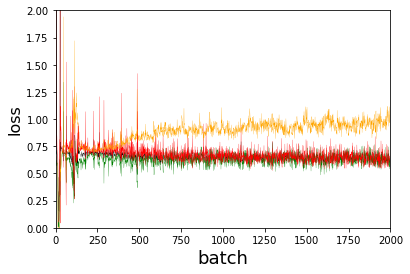

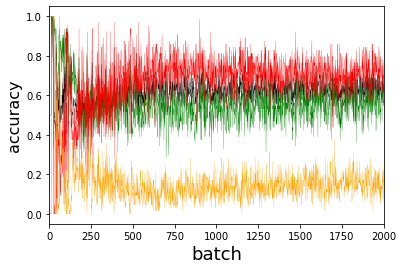

In [ ]:
fig = plt.figure()
plt.plot([x[0] for x in d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()

fig = plt.figure()
plt.plot([x[3] for x in d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()

최종 학습된 결과를 random gaussian noise를 이용하여 생성

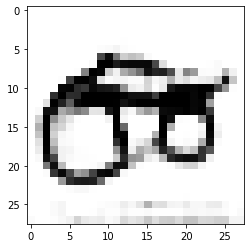

In [ ]:
import numpy as np
#z_dim = 100

noise = np.random.normal(0, 1, (1, z_dim))
img = generator.predict(noise)
plt.imshow(img[0].squeeze(), cmap='binary')
plt.show()

epoch 20 생성 샘플

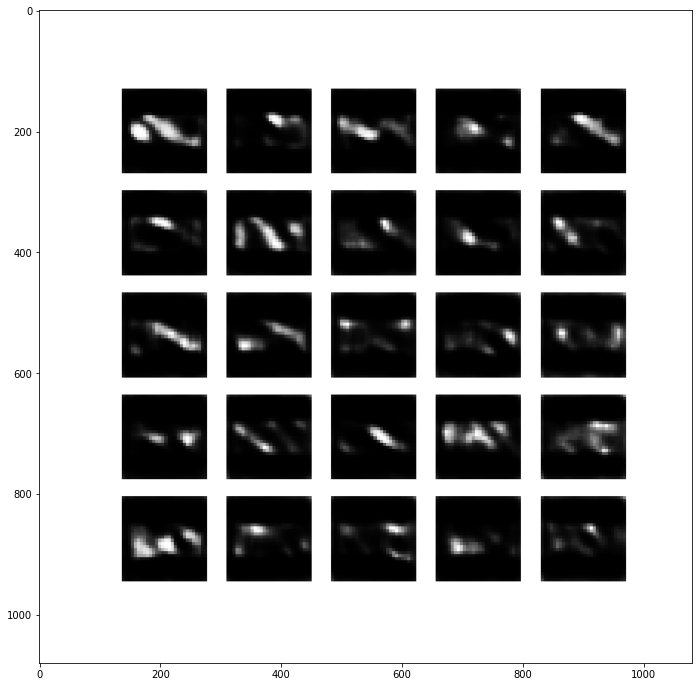

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

image = mp_image.imread('gan_data/images/sample_%d.png' % 20)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

epoch 100 생성 샘플

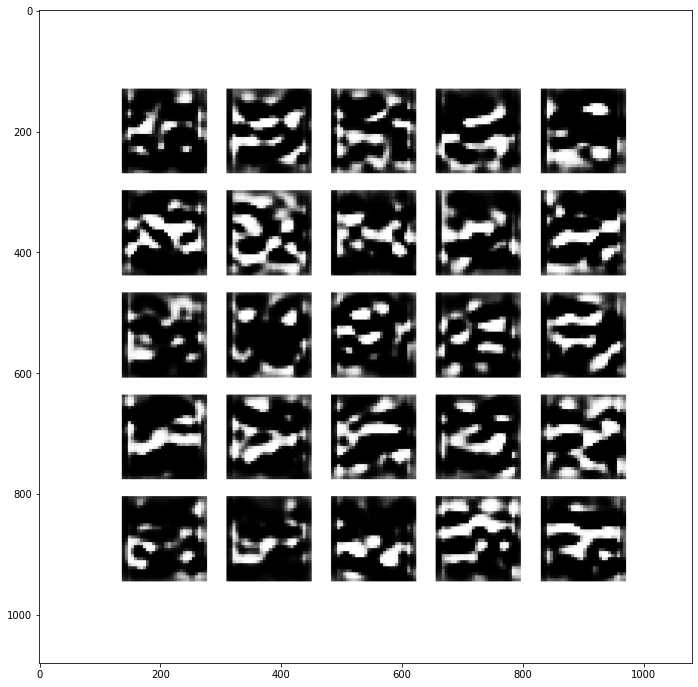

In [ ]:
image = mp_image.imread('gan_data/images/sample_%d.png' % 100)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

epoch 200 생성 샘플

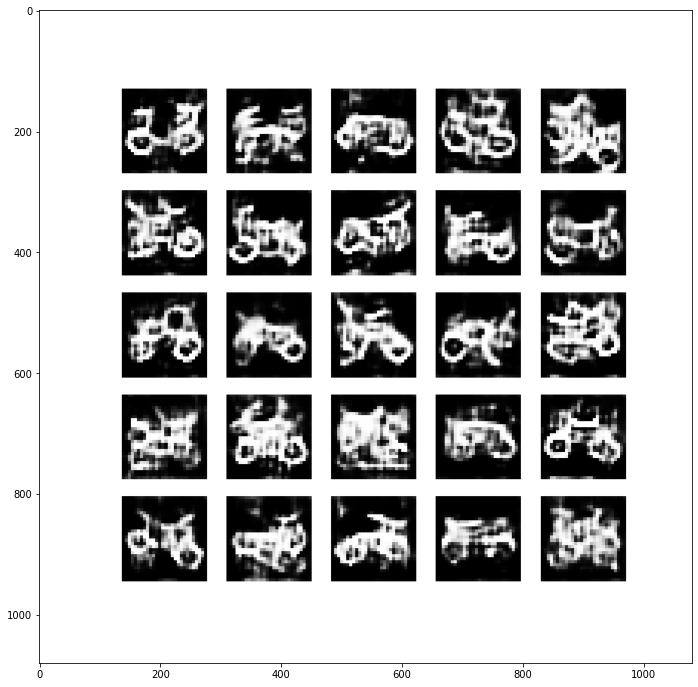

In [ ]:
image = mp_image.imread('gan_data/images/sample_%d.png' % 200)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

epoch 1980 생성 샘플

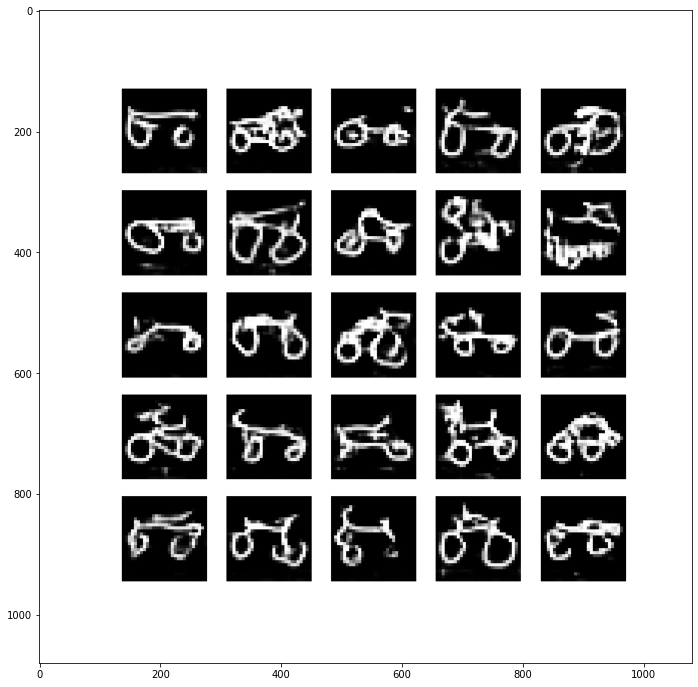

In [ ]:
image = mp_image.imread('gan_data/images/sample_%d.png' % 1980)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()